### ClinScores initial data load experiment

In [1]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric
import math

strawberry


In [2]:
from twaidata.torchdatasets.whole_brain_dataset import MRISegmentationDatasetFromFile
from twaidata.torchdatasets.in_ram_ds import MRISegmentation3DDataset
import pandas as pd

In [3]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
import torch.distributions as td
from typing import Tuple
from torch.utils.data import Dataset

In [4]:
ckpt_dir = None
is3D = False
scratch = 'scratch_big'
root_dir = f"/disk/{scratch}/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domain_names = ["domainA", "domainB", "domainC", "domainD"]
domains = [ed_dir + d for d in domain_names]
# domains = [ wmh_dir + d for d in ['Singapore', 'GE3T', 'Utrecht']]

train_proportion = 0.7
test_proportion = 0.15
validation_proportion = 0.15
seed = 3407

### Todo, put the dataloading bit below into a script now plz

In [5]:
# because we are splitting into train and test at this stage, I should also load in the labels at this stage and split everything off

in_disk_img_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData/"
clin_path = "/home/s2208943/ipdis/data/preprocessed_data/Ed_CVD_tabledata/CVD_clinScores_dataset.csv"

def get_clinscores(imgs_dir, clinScores_filepath, domain):
    # get list of individuals (IDs) for that file
    files_ds = MRISegmentationDatasetFromFile(os.path.join(imgs_dir, domain), 
                 img_filetypes=["FLAIR_BET_mask.nii.gz", "FLAIR.nii.gz", "T1.nii.gz"], # brain mask, flair, T1.
                 label_filetype="wmh.nii.gz")
    individuals = files_ds.individuals
    
    df = pd.read_csv(clinScores_filepath)
    filtered = df.loc[df['ID'].isin(individuals)]

    return filtered

domain_clinscore_tables = [get_clinscores(in_disk_img_dir, clin_path, domainname) for domainname in domain_names]

In [6]:
datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=None) for domain in domains]

In [7]:
from torch.utils.data import Dataset

class ImgAndClinScoreDataset3d(Dataset):
    def __init__(self, base_dataset, domain, transforms=None):
        super().__init__()
        self.base_dataset = base_dataset
        self.clinscore_df = get_clinscores(in_disk_img_dir, clin_path, domain)
        assert len(self.base_dataset) == len(self.clinscore_df)
        self.transforms = transforms
        
    def __getitem__(self, idx):
        pair = self.base_dataset[idx]
        
        if self.transforms:
            pair = self.transforms(pair)
            
        return (*pair, self.clinscore_df.iloc[idx])
    
    def __len__(self):
        return len(self.base_dataset)

In [8]:
clinscore_datasets = [ImgAndClinScoreDataset3d(datasets_domains[i], domain_names[i], transforms=None) for i in range(len(domains))]

In [9]:
def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test

def domains_to_splits(domain_datasets):

    datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in domain_datasets]

    # concat the train val test datsets
    train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
    val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
    test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])
    
    return train_dataset_3d, val_dataset_3d, test_dataset_3d


In [10]:
train_ds, val_ds, test_ds = domains_to_splits(datasets_domains)
train_clinscore_ds, val_clinscore_ds, test_clinscore_ds = domains_to_splits(clinscore_datasets)

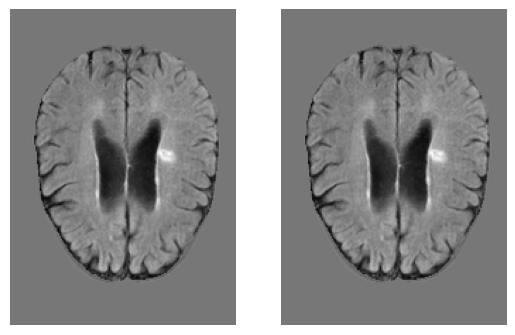

In [11]:
# check that these are indeed the same
plt.subplot(1, 2, 1)
plt.imshow(val_ds[5][0][0][25], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(val_clinscore_ds[5][0][0][25], cmap='gray')
plt.axis('off');

### getting a 2D dataloader to verify the model

In [12]:
### 3d to 2d dataset
class MRISegDataset2DFrom3D(Dataset):
    def __init__(self, dataset3D, transforms=None):
        # calculate total number of slices (note need to iterate through every item
        # because each image may have a different number of slices
        size = 0
        for data in dataset3D:
            x = data[0]
            size += x.shape[1]
            
        self.size = size
        self.dataset3D = dataset3D
        self.transforms = transforms
        
        idx_to_scan_index = []
        scan_starting_index = []
        
        scan_count = 0
        starting_index = 0
        for (ind, _) in dataset3D:
            d_size = ind.shape[1] # slices are the second dim of 3D scan
            idx_to_scan_index.append(torch.ones(d_size) * scan_count)
            scan_starting_index.append(starting_index)
            
            scan_count += 1
            starting_index += d_size
            
        self.idx_to_scan = torch.cat(idx_to_scan_index, dim=0).type(torch.int32)
        # print(self.idx_to_scan.shape)
        self.scan_starting_index = scan_starting_index
        
    def __getitem__(self, idx):
        # find out which scan to use
        scan_idx = self.idx_to_scan[idx]
        # get that dataset
        scan_img, scan_label = self.dataset3D[scan_idx]
        # find out where the element is in that dataset
        item_idx = idx - self.scan_starting_index[scan_idx]
        
        #print(scan_img.shape, scan_label.shape)
        slice_x = scan_img[:, item_idx]
        slice_y = scan_label[:, item_idx] # slices are the second dim of a 3D scan (its channels, z, x, y for 3D scans)
        
        if self.transforms:
            slice_x, slice_y = self.transforms(slice_x, slice_y)
        
        return slice_x, slice_y
        
    def __len__(self):
        return self.size

In [13]:
### empty slice splitting
class FilteredEmptyElementsDataset(Dataset):
    def __init__(self, dataset, seed, transforms=None, empty_proportion_retained=0.1):
        # print(len(dataset))
        self.base_dataset = dataset
        self.transforms = transforms
        empty_indices = []
        self.non_empty_indices = []
        count = 0
        for i, (x, y) in enumerate(dataset):
            if y.sum() == 0:
                count += 1
                empty_indices.append(i)
            else:
                self.non_empty_indices.append(i)
           
        # print(count)
        # print(len(self.non_empty_indices))
        #print(count * empty_proportion_retained)
                
        # extract only a limited proportion of empty slices (take a random selection)
        shuffled_indices = torch.randperm(count, generator=torch.Generator().manual_seed(seed))
        emtpy_indices = torch.Tensor(empty_indices)
        self.retained_empty_indices = torch.Tensor(empty_indices)[shuffled_indices[0:int(count * empty_proportion_retained)]]
        self.size = len(self.non_empty_indices) + len(self.retained_empty_indices)
        self.non_empty_size = len(self.non_empty_indices)
        
            
    def __getitem__(self, idx):
        if idx >= self.non_empty_size:
            # select an empty slice
            new_idx = self.retained_empty_indices[idx - self.non_empty_size]
        else:
            # select a slice with label in it
            new_idx = self.non_empty_indices[idx]
        new_idx = int(new_idx)
        
        img, label = self.base_dataset[new_idx]
        
        if self.transforms:
            img, label = self.transforms(img, label)
            
        return img, label

    def __len__(self):
        return self.size

In [14]:
def get_transforms():
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        RandomAffine(p=0.2, shear=(-18,18)),
        RandomAffine(p=0.2, degrees=15),
        RandomAffine(p=0.2, translate=(-0.1,0.1)),
        RandomAffine(p=0.2, scale=(0.9, 1.1)),
#         #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))

#         #RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
            
    ]
    transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
    return PairedCompose(transforms)

In [15]:
datasets_2d = [MRISegDataset2DFrom3D(ds, transforms=None) for ds in [train_ds, val_ds, test_ds]]

In [16]:
train_ds2d, val_ds2d, test_ds2d = [FilteredEmptyElementsDataset(ds, seed=seed, transforms=get_transforms()) for ds in datasets_2d]

In [17]:
# define dataloaders
train_dataloader = DataLoader(train_ds2d, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_ds2d, batch_size = 30, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_ds2d, batch_size=64, shuffle=False, num_workers=4)

### defining and loading up a trained model

In [18]:
def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

In [19]:
class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()   

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as transforms

class HmResBlock(nn.Module):
    def __init__(self, channels, p):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=7, stride=1, dilation=2, padding='same')
        self.dropout1 = nn.Dropout2d(p)
        self.norm1 = nn.InstanceNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, dilation=2, padding='same')
        self.norm2 = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.dropout1(out)
        
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        out = out + identity
        
        return out
    
class DownBlock(nn.Module):
    def __init__(self, ins, outs):
        super().__init__()
        self.conv = nn.Conv2d(ins, outs, kernel_size=3, stride=2, dilation=1, padding=1)
        self.norm = nn.InstanceNorm2d(outs)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        return self.activ(self.norm(self.conv(x)))

class HmUpsampBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels*2, channels, kernel_size=3, stride=1, dilation=1, padding='same')
        self.norm = nn.InstanceNorm2d(channels)
        self.activ = nn.ReLU()
        
    def forward(self, x):
        out = F.interpolate(x, scale_factor=2, mode='bilinear')
        return self.activ(self.norm(self.conv(out)))
        

class HmFeatureBlock(nn.Module):
    def __init__(self, ins):
        super().__init__()
        self.conv1 = nn.Conv2d(ins, ins//2, kernel_size=3, stride=1, dilation=2, padding='same')
        self.activ = nn.ReLU()
        self.norm1 = nn.InstanceNorm2d(ins)
        self.conv2 = nn.Conv2d(ins//2, ins//2, kernel_size=1, stride=1, dilation=1)
        self.norm2 = nn.InstanceNorm2d(ins)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.activ(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = self.activ(out)
        
        return out
    
class HyperMapREDO(nn.Module):
    def __init__(self,dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, outchannels=2):
        super().__init__()
        
        
        # input layer
        self.conv_first = nn.Conv2d(inchannels, encoder_sizes[0], kernel_size=5, stride=1, dilation=1, padding='same')
        self.activ = nn.ReLU()
        
        # encoder section
        l = len(encoder_sizes) - 1
        self.down_blocks = nn.ModuleList([
            DownBlock(encoder_sizes[i], encoder_sizes[i+1]) for i in range(0, l)
        ])
        
        self.res_blocks = nn.ModuleList([
            HmResBlock(c, dropout_p) for c in encoder_sizes
        ])
        
        # decoder section
        self.upsample_blocks = nn.ModuleList([
            HmUpsampBlock(c) for c in encoder_sizes[:-1][::-1]
        ])
        
        self.feature_blocks = nn.ModuleList([
            HmFeatureBlock(encoder_sizes[l - i]) for i in range(l-1)
        ])
        
        
        # multi-scale feature section
        self.ms_feature_layers = nn.ModuleList([
            nn.Conv2d(encoder_sizes[2], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same'),
            nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        ])
        
        
        # output layer
        self.last_1 = nn.Conv2d(encoder_sizes[1], encoder_sizes[1], 3, padding='same')
        self.last_2 = nn.Conv2d(encoder_sizes[1]*3, encoder_sizes[1], 1)
        self.last_3 = nn.Conv2d(encoder_sizes[1], outchannels, 1)
        self.last_norm = nn.InstanceNorm2d(encoder_sizes[1])
        
    def forward(self, x):
        # input layer
        out = self.activ(self.conv_first(x))
        # print(out.shape)
        
        skips = []
        
        # encoder section
        out = self.res_blocks[0](out)
        # print(out.shape)
        skips.append(out)
        for i in range(len(self.res_blocks) - 1):
            out = self.down_blocks[i](out)
            out = self.res_blocks[i+1](out)
            # print("loop: ", out.shape)
            skips.append(out)
        
        # decoder section
        ml_features = []
        out = skips.pop()
        for i in range(len(self.upsample_blocks)):
            # print("dec")
            if i > 0:
                sk = skips.pop()
                sk = transforms.center_crop(sk, out.shape[-2:])
                out = torch.cat([out, sk], dim=1)
                out = self.feature_blocks[i-1](out)
            
            if i > 1:
                ml_features.append(self.ms_feature_layers[i-2](out))
                
            out = self.upsample_blocks[i](out)
        
        # final layers
        sk = skips.pop()
        sk = transforms.center_crop(sk, out.shape[-2:])
        out = torch.cat([out, sk], dim=1)
        out = self.last_norm(self.activ(self.last_1(out)))
        
        # multiscale feature section
        ml_features = [out] + ml_features
        ml_features = [F.interpolate(mf, size=x.shape[-2:], mode='bilinear') for mf in ml_features]
        combined_features = torch.cat(ml_features, dim=1)
        
        out = self.activ(self.last_2(combined_features))
        out = self.last_3(out)
        
        return out
        

In [21]:
from torch.distributions.multivariate_normal import _batch_mahalanobis, _batch_mv
from torch.distributions.utils import _standard_normal, lazy_property
import math
from torch.distributions import constraints

class LowRankMultivariateNormalCustom(td.Distribution):
    r"""
    Creates a multivariate normal distribution with covariance matrix having a low-rank form
    parameterized by :attr:`cov_factor` and :attr:`cov_diag`::

        covariance_matrix = cov_factor @ cov_factor.T + cov_diag

    Example:
        >>> # xdoctest: +REQUIRES(env:TORCH_DOCTEST_LAPACK)
        >>> # xdoctest: +IGNORE_WANT("non-determenistic")
        >>> m = LowRankMultivariateNormal(torch.zeros(2), torch.tensor([[1.], [0.]]), torch.ones(2))
        >>> m.sample()  # normally distributed with mean=`[0,0]`, cov_factor=`[[1],[0]]`, cov_diag=`[1,1]`
        tensor([-0.2102, -0.5429])

    Args:
        loc (Tensor): mean of the distribution with shape `batch_shape + event_shape`
        cov_factor (Tensor): factor part of low-rank form of covariance matrix with shape
            `batch_shape + event_shape + (rank,)`
        cov_diag (Tensor): diagonal part of low-rank form of covariance matrix with shape
            `batch_shape + event_shape`

    Note:
        The computation for determinant and inverse of covariance matrix is avoided when
        `cov_factor.shape[1] << cov_factor.shape[0]` thanks to `Woodbury matrix identity
        <https://en.wikipedia.org/wiki/Woodbury_matrix_identity>`_ and
        `matrix determinant lemma <https://en.wikipedia.org/wiki/Matrix_determinant_lemma>`_.
        Thanks to these formulas, we just need to compute the determinant and inverse of
        the small size "capacitance" matrix::

            capacitance = I + cov_factor.T @ inv(cov_diag) @ cov_factor
    """
    arg_constraints = {"loc": constraints.real_vector,
                       "cov_factor": constraints.independent(constraints.real, 2),
                       "cov_diag": constraints.independent(constraints.positive, 1)}
    support = constraints.real_vector
    has_rsample = True

    def __init__(self, loc, cov_factor, cov_diag, validate_args=None):
        if loc.dim() < 1:
            raise ValueError("loc must be at least one-dimensional.")
        event_shape = loc.shape[-1:]
        if cov_factor.dim() < 2:
            raise ValueError("cov_factor must be at least two-dimensional, "
                             "with optional leading batch dimensions")
        if cov_factor.shape[-2:-1] != event_shape:
            raise ValueError("cov_factor must be a batch of matrices with shape {} x m"
                             .format(event_shape[0]))
        if cov_diag.shape[-1:] != event_shape:
            raise ValueError("cov_diag must be a batch of vectors with shape {}".format(event_shape))

        loc_ = loc.unsqueeze(-1)
        cov_diag_ = cov_diag.unsqueeze(-1)
        try:
            loc_, self.cov_factor, cov_diag_ = torch.broadcast_tensors(loc_, cov_factor, cov_diag_)
        except RuntimeError as e:
            raise ValueError("Incompatible batch shapes: loc {}, cov_factor {}, cov_diag {}"
                             .format(loc.shape, cov_factor.shape, cov_diag.shape)) from e
        self.loc = loc_[..., 0]
        self.cov_diag = cov_diag_[..., 0]
        batch_shape = self.loc.shape[:-1]

        self._unbroadcasted_cov_factor = cov_factor
        self._unbroadcasted_cov_diag = cov_diag
        #self._capacitance_tril = _batch_capacitance_tril(cov_factor, cov_diag)
        super().__init__(batch_shape, event_shape,
                                                        validate_args=validate_args)

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(LowRankMultivariateNormal, _instance)
        batch_shape = torch.Size(batch_shape)
        loc_shape = batch_shape + self.event_shape
        new.loc = self.loc.expand(loc_shape)
        new.cov_diag = self.cov_diag.expand(loc_shape)
        new.cov_factor = self.cov_factor.expand(loc_shape + self.cov_factor.shape[-1:])
        new._unbroadcasted_cov_factor = self._unbroadcasted_cov_factor
        new._unbroadcasted_cov_diag = self._unbroadcasted_cov_diag
        new._capacitance_tril = self._capacitance_tril
        super(LowRankMultivariateNormal, new).__init__(batch_shape,
                                                       self.event_shape,
                                                       validate_args=False)
        new._validate_args = self._validate_args
        return new


    @property
    def mean(self):
        return self.loc

    @property
    def mode(self):
        return self.loc

    @lazy_property
    def variance(self):
        return (self._unbroadcasted_cov_factor.pow(2).sum(-1)
                + self._unbroadcasted_cov_diag).expand(self._batch_shape + self._event_shape)

    @lazy_property
    def scale_tril(self):
        # The following identity is used to increase the numerically computation stability
        # for Cholesky decomposition (see http://www.gaussianprocess.org/gpml/, Section 3.4.3):
        #     W @ W.T + D = D1/2 @ (I + D-1/2 @ W @ W.T @ D-1/2) @ D1/2
        # The matrix "I + D-1/2 @ W @ W.T @ D-1/2" has eigenvalues bounded from below by 1,
        # hence it is well-conditioned and safe to take Cholesky decomposition.
        n = self._event_shape[0]
        cov_diag_sqrt_unsqueeze = self._unbroadcasted_cov_diag.sqrt().unsqueeze(-1)
        Dinvsqrt_W = self._unbroadcasted_cov_factor / cov_diag_sqrt_unsqueeze
        K = torch.matmul(Dinvsqrt_W, Dinvsqrt_W.mT).contiguous()
        K.view(-1, n * n)[:, ::n + 1] += 1  # add identity matrix to K
        scale_tril = cov_diag_sqrt_unsqueeze * torch.linalg.cholesky(K)
        return scale_tril.expand(self._batch_shape + self._event_shape + self._event_shape)

    @lazy_property
    def covariance_matrix(self):
        covariance_matrix = (torch.matmul(self._unbroadcasted_cov_factor,
                                          self._unbroadcasted_cov_factor.mT)
                             + torch.diag_embed(self._unbroadcasted_cov_diag))
        return covariance_matrix.expand(self._batch_shape + self._event_shape +
                                        self._event_shape)

    @lazy_property
    def precision_matrix(self):
        # We use "Woodbury matrix identity" to take advantage of low rank form::
        #     inv(W @ W.T + D) = inv(D) - inv(D) @ W @ inv(C) @ W.T @ inv(D)
        # where :math:`C` is the capacitance matrix.
        Wt_Dinv = (self._unbroadcasted_cov_factor.mT
                   / self._unbroadcasted_cov_diag.unsqueeze(-2))
        A = torch.linalg.solve_triangular(self._capacitance_tril, Wt_Dinv, upper=False)
        precision_matrix = torch.diag_embed(self._unbroadcasted_cov_diag.reciprocal()) - A.mT @ A
        return precision_matrix.expand(self._batch_shape + self._event_shape +
                                       self._event_shape)

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        W_shape = shape[:-1] + self.cov_factor.shape[-1:]
        eps_W = _standard_normal(W_shape, dtype=self.loc.dtype, device=self.loc.device)
        eps_D = _standard_normal(shape, dtype=self.loc.dtype, device=self.loc.device)
        return (self.loc + _batch_mv(self._unbroadcasted_cov_factor, eps_W)
                + self._unbroadcasted_cov_diag.sqrt() * eps_D)


    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        diff = value - self.loc
        M = _batch_lowrank_mahalanobis(self._unbroadcasted_cov_factor,
                                       self._unbroadcasted_cov_diag,
                                       diff,
                                       self._capacitance_tril)
        log_det = _batch_lowrank_logdet(self._unbroadcasted_cov_factor,
                                        self._unbroadcasted_cov_diag,
                                        self._capacitance_tril)
        return -0.5 * (self._event_shape[0] * math.log(2 * math.pi) + log_det + M)


    def entropy(self):
        log_det = _batch_lowrank_logdet(self._unbroadcasted_cov_factor,
                                        self._unbroadcasted_cov_diag,
                                        self._capacitance_tril)
        H = 0.5 * (self._event_shape[0] * (1.0 + math.log(2 * math.pi)) + log_det)
        if len(self._batch_shape) == 0:
            return H
        else:
            return H.expand(self._batch_shape)

In [22]:
class HyperMapp3rSSN2(HyperMapREDO):
    def __init__(self,
                 dropout_p = 0., encoder_sizes=[16,32,64,128,256], inchannels=3, out_channels=2,
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False,
                 dims=2
                ):
        super().__init__(dropout_p, encoder_sizes, inchannels, outchannels=encoder_sizes[0]) # last layer of just keeps number of nodes fixed this time)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(encoder_sizes[0], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(encoder_sizes[0], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(encoder_sizes[0], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')
        #self.vk_l = conv_func(encoder_sizes[0], 2, kernel_size=7, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))

        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
            
            
        #vk = self.vk_l(logits).exp()
        # print(vk.shape)
        #vk = vk.mean(dim=(-1, -2)) # mean along each axis except for channel, yielding two values
        #D = mean.shape[1]
        #v = vk[:,0]
        #k = vk[:,1]
        #evidence_scale = (k+1) / (k*v)
        
        # print("vk shapes")
        # print(v.shape)
        # print(k.shape)
        # print(v, k, evidence_scale)
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # print(evidence_scale.shape, (evidence_scale**0.5).shape)
        # print(cov_diag.shape, cov_factor.shape)
#         cov_diag *= evidence_scale.unsqueeze(-1)
#         cov_factor *= (evidence_scale**0.5).unsqueeze(-1).unsqueeze(-1)
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
            
        # print(cov_diag)
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = LowRankMultivariateNormalCustom(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #base_distribution = LowRankMultivariateStudentT_V3(df=v, loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        # compute the diagonal of the precision matrix for the evidence regularizer
#         U = cov_factor
#         D_inv = 1./cov_diag
#         # print("shapes for regularizer")
#         # print("U, U.mt", U.shape, U.mT.shape)
#         # print("D", D_inv.shape)
        
#         D_inv_mult = D_inv.unsqueeze(-1).expand(U.shape)
#         # print("D inv mult", D_inv_mult.shape)
        
#         F = torch.eye(self.ssn_rank).to(U.device) + U.mT.bmm(D_inv_mult * U)
#         # print("F", F.shape)
        
#         RRT = torch.cholesky_inverse(F)
#         R = torch.cholesky(RRT)
        
#         # print("R", R.shape)
#         V = (D_inv_mult * U).bmm(R)
#         # print("V", V.shape)
        
#         # print("diag v", torch.diagonal(V, dim1=1, dim2=2).shape, V.shape)
        
#         pres_diag = D_inv - torch.sum(V * V, dim=2) # get the diagonal of the V@V.T matrix without computing it
             
        
        output_dict = {
            # 'v':v,
            # 'k':k,
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
            # 'pres_diag':pres_diag,
        }
        
        return output_dict

In [23]:
def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

In [24]:
def fixed_re_parametrization_trick(dist, num_samples):
    assert num_samples % 2 == 0
    samples = dist.rsample((num_samples // 2,))
    mean = dist.mean.unsqueeze(0)
    samples = samples - mean
    return torch.cat([samples, -samples]) + mean

In [25]:
class StochasticSegmentationNetworkLossMCIntegral(nn.Module):
    def __init__(self, num_mc_samples: int = 1):
        super().__init__()
        self.num_mc_samples = num_mc_samples

    @staticmethod
    def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean

    def forward(self, result_dict, target, **kwargs):
        logits = result_dict['logit_mean']
        distribution = result_dict['distribution']
        
        batch_size = logits.shape[0]
        num_classes = logits.shape[1]
        assert num_classes >= 2  # not implemented for binary case with implied background
        # logit_sample = distribution.rsample((self.num_mc_samples,))
        logit_sample = self.fixed_re_parametrization_trick(distribution, self.num_mc_samples)
        target = target.unsqueeze(1)
        target = target.expand((self.num_mc_samples,) + target.shape)

        flat_size = self.num_mc_samples * batch_size
        logit_sample = logit_sample.view((flat_size, num_classes, -1))
        target = target.reshape((flat_size, -1))

        log_prob = -F.cross_entropy(logit_sample, target, reduction='none').view((self.num_mc_samples, batch_size, -1))
        loglikelihood = torch.mean(torch.logsumexp(torch.sum(log_prob, dim=-1), dim=0) - math.log(self.num_mc_samples))
        loss = -loglikelihood
        return loss
    
def fixed_re_parametrization_trick(dist, num_samples):
        assert num_samples % 2 == 0
        samples = dist.rsample((num_samples // 2,))
        mean = dist.mean.unsqueeze(0)
        samples = samples - mean
        return torch.cat([samples, -samples]) + mean


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
    
def avd(logits, target):
    preds = torch.nn.functional.softmax(logits, dim=1)[:,1]
    bs = preds.shape[0]
    preds = preds.view(bs, -1)
    target = target.view(bs, -1)

    vd = torch.sum(target, dim=1) - torch.sum(preds, dim=1)
    avd = vd.abs()
    l = avd.sum()
    return l
    
    
class SsnNetworkMuAndSamplesLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        s = result_dict['distribution'].mean # samples[0]
        #print(s.shape, result_dict['distribution'].mean.shape)
        dice = self.loss(s, target)
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        
        return dice + ((0.1*loss) / self.samples)
    
class SsnDiceMetricWrapper(DiceLossMetric):

    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()

In [26]:
ssn_diceloss = SsnNetworkMuAndSamplesLossWrapper(dice_loss)# SsnNetworkMeanLossWrapper(dice_loss)
mc_loss = StochasticSegmentationNetworkLossMCIntegral(num_mc_samples=10)

In [27]:
class StandardLitModelWrapper(pl.LightningModule):
        def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                    optimizer_constructor=None, lr_scheduler_constructor=None):
            super().__init__()
            self.model = model
            self.loss = loss
            self.logging_metric_train = logging_metric()
            self.logging_metric_val = logging_metric()
            self.optim_params = optimizer_params
            self.lr_scheduler_params = lr_scheduler_params
            self.is_uq_model = False
            self.optimizer_constructor = optimizer_constructor
            self.lr_scheduler_constructor = lr_scheduler_constructor


        def forward(self, x, **kwargs):
            return self.model(x, **kwargs)

        def configure_optimizers(self):
            # optimizer and schedulers go in the configure optimizers hook
            if self.optimizer_constructor:
                optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
            else:
                optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)

            if self.lr_scheduler_constructor:
                lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
            else:
                lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)

            return [optimizer], [lr_scheduler]

        def training_step(self, batch, batch_idx):
            """
            lightning automates the training loop, 
            does epoch, back_tracking, optimizers and schedulers,
            and metric reduction.
            we just define how we want to process a single batch. 
            we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
            hook, and I presume we can add our own parameters also to functions?
            """

            if self.is_uq_model:
                self.model.set_applyfunc(True)

            X, y = batch
            y_hat = self(X)
            loss = self.loss(y_hat, y)

            # metrics 
            if self.logging_metric_train:
                self.logging_metric_train(y_hat, y)
                self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
            self.log("train_loss", loss)

            return loss

    #     def training_epoch_end(self, outs):
    #         self.log('train_metric_epoch', self.logging_metric_train.compute())

    #     def validation_epoch_end(self, outs):
    #         self.log('val_metric_epoch', self.logging_metric_val.compute())

        def validation_step(self, batch, batch_idx):
            """
            note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
            well yes I want to enable checkpointing but will deal with that later.
            also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
            I will need a custom eval thing to do my dropout estimation but can solve that later too.
            """
            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            val_loss = self.loss(y_hat, y)

            if self.logging_metric_val:
                self.logging_metric_val(y_hat, y)
                self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
            self.log("val_loss", val_loss)

        def test_step(self, batch, batch_idx):
            """
            we would need to directly call this function using the trainer
            """

            if self.is_uq_model:
                self.model.set_applyfunc(False)

            X, y = batch
            y_hat = self(X)
            test_loss = self.loss(y_hat, y)
            self.log("test_loss", test_loss)

        def predict_step(self, batch, batch_idx):
            """
            just for making predictions as opposed to collecting metrics etc
            note to use this, we just call .predict(dataloader) and it then automates the look
            these functions are for a single batch. Nice.
            """
            X, y = batch
            pred = self(X)
            return pred

In [28]:
dice_factor = 5
#avd_factor = 0.001
    
def double_loss(outs, target):
    dice = ssn_diceloss(outs, target)
    return dice * dice_factor + mc_loss(outs, target) * 0.01

def triple_loss(outs, target):
    main_loss = ssn_diceloss(outs, target) * dice_factor + mc_loss(outs, target) * 0.01
    
    if main_loss < 60:
        main_loss += correction_loss(outs, target) * 0.1
    return main_loss



In [29]:
loss = double_loss

In [30]:
model_raw = HyperMapp3rSSN2(ssn_rank=15).cuda()

In [31]:
loss = double_loss
#loss = triple_loss

optimizer_params={"lr":2e-4}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[1000], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

model = StandardLitModelWrapper(model_raw, loss, 
                                logging_metric=SsnDiceMetricWrapper, # lambda : None,
                                optimizer_params=optimizer_params,
                                lr_scheduler_params=lr_scheduler_params,
                                is_uq_model=False,
                                optimizer_constructor=optimizer,
                                lr_scheduler_constructor=lr_scheduler_constructor
                               )

# model = StandardLitModelWrapper.load_from_checkpoint(trained_ckpt_dir + trained_model,
#                                                      model_raw, loss, 
#                                 logging_metric=SsnDiceMetricWrapper, # lambda : None,
#                                )

In [32]:
accelerator="gpu"
devices=1
max_epochs=1000
precision = 32

rootdir = f"/disk/{scratch}/s2208943/results/new_tests/evid_ssn"
final_dir = rootdir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=-1, monitor="val_loss", every_n_epochs=5)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=15, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)

#trainer.fit(model, train_dataloader, val_dataloader,)# ckpt_path='/disk/scratch_big/s2208943/results/new_tests/epoch=15-step=2192.ckpt')

/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/lightning_lite/plugins/environments/slurm.py:167: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/s2208943/miniconda3/envs/uq/lib/python3.10/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
def ndigit(n, x):
    s = str(x)
    ns = "0" * (n - len(s))
    return ns + s

In [34]:
root = "/home/s2208943/ipdis/results/final_models/"
folders = ["new_ssn_ens" + ndigit(2, x+11) + "/" for x in range(10)]

In [35]:
cs = []
for f in folders:
    ckpts = sorted([c for c in os.listdir(root+f) if "epoch" in c])
    c = ckpts[-2] # the second from last seems to be the 'best' checkpoint
    cs.append(c)

In [36]:
f = folders[2]
c = cs[2]
model = StandardLitModelWrapper.load_from_checkpoint(root + f + c, model=model_raw, loss=loss, 
                            logging_metric=SsnDiceMetricWrapper).cuda()
print("checkpoint: ", root + f + c)
trainer.validate(model, val_dataloader)

checkpoint:  /home/s2208943/ipdis/results/final_models/new_ssn_ens13/epoch=28-step=4263.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss             5.254732131958008
    val_metric_epoch        0.3934641480445862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.3934641480445862, 'val_loss': 5.254732131958008}]

### Iterate over the 3D dataset, generate the uncertainty map for each image, and store the data

In [37]:
from tqdm import tqdm

In [38]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

In [39]:
# dataset = train_clinscore_ds
# dataset = ConcatDataset([val_clinscore_ds, test_clinscore_ds])
dataset = ConcatDataset([train_clinscore_ds, val_clinscore_ds, test_clinscore_ds])

In [40]:
ent_maps = []
clin_values = []
means = []
sample_means = []

for x, y, values in tqdm(dataset, position=0, leave=True):
    with torch.no_grad():
        out = model.cuda()(x.cuda().swapaxes(0,1))
        samples = fixed_re_parametrization_trick(out['distribution'], 20)
        ent_map = entropy_map_from_samples(samples)
        ent_maps.append(ent_map.cpu())
        means.append(out['distribution'].mean.cpu())
        sample_means.append(samples.mean(dim=0).cpu())
        clin_values.append(values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:05<00:00,  3.80it/s]


In [41]:
clin_values[0]

Unnamed: 0                  45
ID                      CVD064
sbjGroup                     1
age                       85.0
sex                          2
diabetes                     0
hypertension                 1
hyperlipidaemia            1.0
smoking                    0.0
SBP                      142.0
DBP                       98.0
totalChl                   5.2
MMSE                       NaN
ICV                1405.845825
WMH                 112.514062
PVWMH                      3.0
DWMH                       3.0
deepAtrophy                0.0
supAtrophy                 2.0
BGPVS                      4.0
CSPVS                      2.0
relLes                     1.0
oldLes                     1.0
micrBld                    3.0
Name: 45, dtype: object

In [42]:
clin_values = pd.DataFrame.from_records(clin_values)

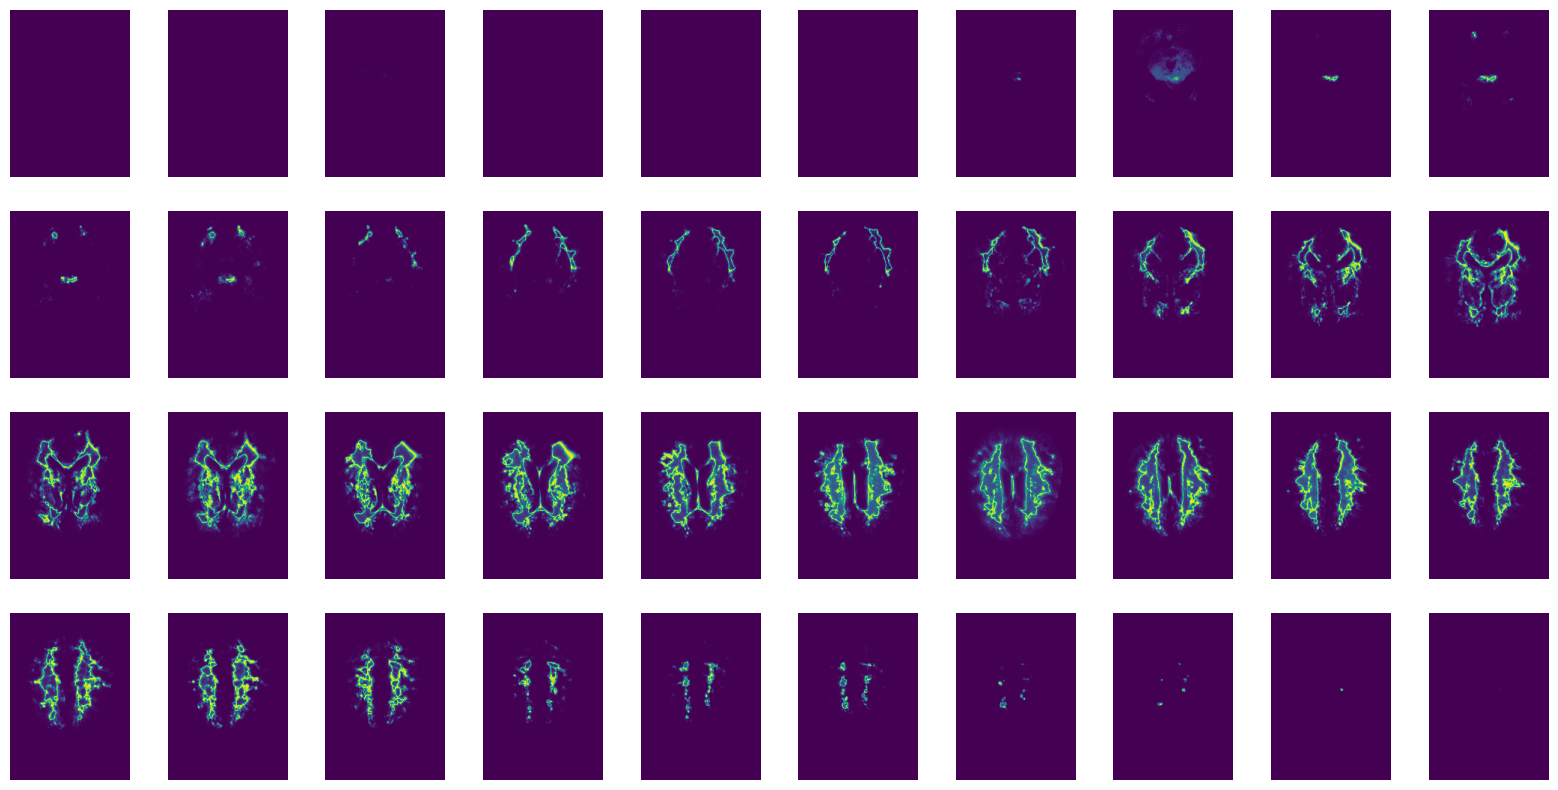

In [43]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(ent_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7)
    plt.axis('off')

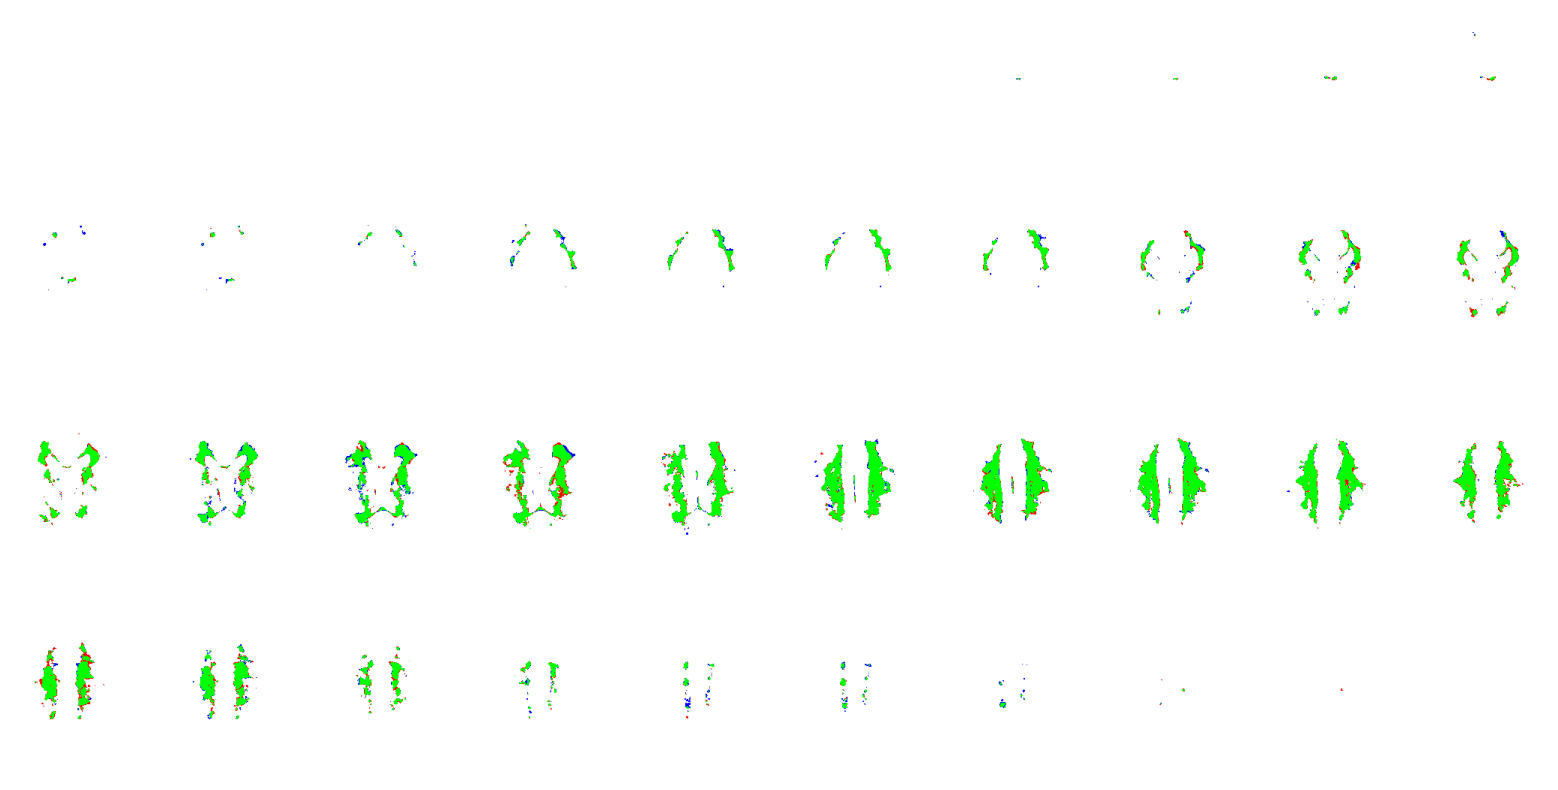

In [44]:
def image_prediction_type_image(target_slice, pred_slice, background_colour='white'):
    tp = target_slice * pred_slice
    fp = (1-target_slice) * pred_slice
    fn = target_slice * (1-pred_slice)
    
    out_image = torch.zeros((*target_slice.shape, 3))

    if background_colour == 'white':
        # # version on white background
        fn = fn.type(torch.bool)
        tp = tp.type(torch.bool)
        fp = fp.type(torch.bool)
        out_image[:,:,:] = 1
        out_image[:,:,1] = 1 - (fn | fp).type(torch.float32)
        out_image[:,:,0] = 1 - (tp | fn).type(torch.float32)
        out_image[:,:,2] = 1 - (tp | fp).type(torch.float32)
        
    else:
        # simple version on black background
        out_image[:,:,1] = tp
        out_image[:,:,0] = fp
        out_image[:,:,2] = fn
        
    return out_image
        
    
# plot the mean segmentation
plt.figure(figsize=(20, 10))
target = dataset[0][1][0]
for i, pred_slice in enumerate(means[0].argmax(dim=1)):
    target_slice = target[i]
    
    out_image = image_prediction_type_image(
        target_slice,
        pred_slice,
        background_colour='white'
    )
    
    plt.subplot(4, 10, i+1)
    plt.imshow(out_image)
    plt.axis('off')

In [45]:
selected = torch.randint(250, (20,))

In [46]:
means[0].shape

torch.Size([40, 2, 224, 160])

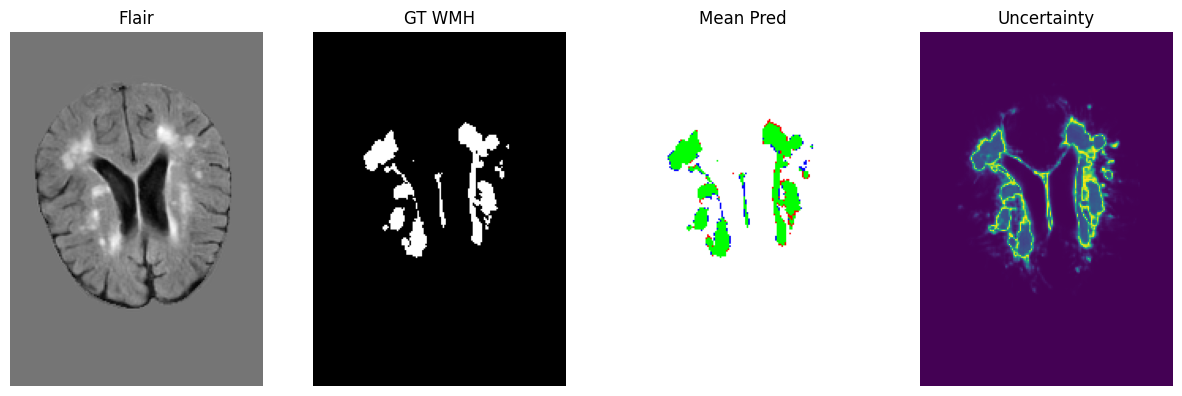

In [47]:
def plot_subimg(img, rows, cols, i, cmap='gray', axis='off', title='', vmin=None, vmax=None):
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis(axis)
    plt.title(title)
    return i + 1

    
rows = 1
cols = 4
i = 1

plt.figure(figsize=(15, 5))
scan_id = 8
slice_id = 25
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
i = plot_subimg(dataset[scan_id][1][0][slice_id], rows=rows, cols=cols, i=i, title='GT WMH')
i = plot_subimg(image_prediction_type_image(dataset[scan_id][1][0][slice_id], means[scan_id][slice_id].argmax(dim=0)), rows=rows, cols=cols, i=i, title='Mean Pred', cmap=None)
i = plot_subimg(ent_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, cmap=None, title='Uncertainty')

plt.savefig("datatypes.png")

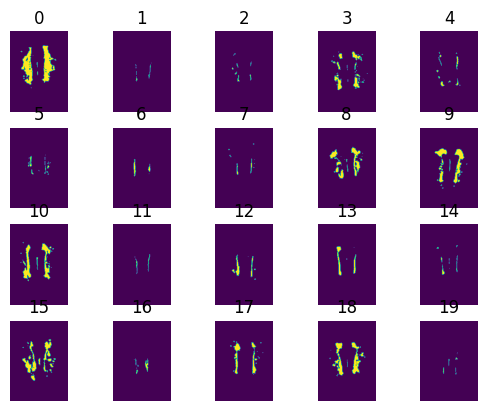

In [48]:
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(means[i].argmax(dim=1)[25])
    plt.axis('off')
    plt.title(i)

In [49]:
individual_dice(means[0], dataset[0][1][0])

tensor([0.0043, 0.0049, 0.0046, 0.0050, 0.0040, 0.0051, 0.2866, 0.2134, 0.2344,
        0.3502, 0.3600, 0.3559, 0.2872, 0.2222, 0.1514, 0.1156, 0.1375, 0.2401,
        0.2196, 0.2344, 0.1816, 0.1783, 0.1825, 0.1769, 0.1387, 0.1055, 0.1017,
        0.0933, 0.0962, 0.1138, 0.1720, 0.1562, 0.1880, 0.2146, 0.3724, 0.2672,
        0.3767, 0.3602, 0.8685, 0.0043])

In [50]:
dice_loss(means[0], dataset[0][1][0])

tensor(0.2037)

In [51]:
clin_values

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,WMH,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,relLes,oldLes,micrBld
0,45,CVD064,1,85.0,2,0,1,1.0,0.0,142.0,...,112.514062,3.0,3.0,0.0,2.0,4.0,2.0,1.0,1.0,3.0
1,67,CVD092,1,55.0,1,1,0,1.0,2.0,124.0,...,3.097266,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
2,65,CVD090,1,75.0,2,0,1,1.0,2.0,125.0,...,4.556250,1.0,1.0,0.0,2.0,3.0,2.0,0.0,1.0,0.0
3,163,CVD237,1,74.0,1,1,1,1.0,1.0,142.0,...,66.885443,3.0,2.0,4.0,2.0,3.0,2.0,1.0,1.0,0.0
4,96,CVD134,1,76.0,1,0,1,0.0,0.0,134.0,...,24.145312,2.0,1.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,162,CVD236,1,64.0,1,1,0,0.0,2.0,123.0,...,13.872656,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
246,203,CVD279,1,63.0,1,1,1,0.0,1.0,146.0,...,1.817578,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
247,94,CVD132,1,56.0,1,0,0,0.0,2.0,130.0,...,3.417187,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
248,192,CVD268,1,69.0,1,1,1,1.0,0.0,140.0,...,79.330078,3.0,3.0,5.0,4.0,2.0,1.0,1.0,0.0,0.0


### TODO next
- build the cin_values back into a pandas df
- decide how to deal with nans for each example (find where the empty string field is and check that there is nothing dodgy going on - e.g rows haven't been displaced by one or something, sanity check the data)
- deicde what metrics I want to compute (e.g Uncertainty vs WMH diff (e.g the uncertainty in areas other than the mean segmentation), uncertainty mass, uncertainty VVC, uncertainty / WMH volume, etc
- think are there other ways of generating the uncertianty map from the samples (now would be a good time to evaluate variance, kernel density estimation etc instead of just mean uncertainty maps)
- do a PCA on the uncertainty metrics I compute, see what parameters explain the uncertainty volume for example
- do some general linear modelling to explain each parameter with and without uncertainty map, see what is useful
- try to say adjust for stroke or whichever factors are important in PCA and see if that accounts for volume difference where the mean prediction is far away from the rest
- look up the paper and email maria sent a long time ago with the other analysis that I need to do.


### Looking at Nan values

In [52]:
for key in clin_values.keys():
    vs = clin_values[key].values
    try:
        nans = np.isnan(vs).sum()
    except:
        nans = 'unknown'
    try:
        uniques = np.unique(vs)
        if len(uniques) < 20:
            print(key, ": ", uniques, ", num nans: ", nans)
        else:
            print(key, ", num nans: ", nans)
    except:
        print(key, " causes problems due to string value" , ", num nans: ", nans)

Unnamed: 0 , num nans:  0
ID , num nans:  unknown
sbjGroup :  [0 1 2] , num nans:  0
age , num nans:  0
sex :  [1 2] , num nans:  0
diabetes :  [0 1] , num nans:  0
hypertension :  [0 1] , num nans:  0
hyperlipidaemia :  [ 0.  1. nan] , num nans:  3
smoking :  [ 0.  1.  2. nan] , num nans:  1
SBP , num nans:  7
DBP , num nans:  7
totalChl  causes problems due to string value , num nans:  unknown
MMSE :  [21. 22. 23. 24. 25. 26. 27. 28. 29. 30. nan] , num nans:  106
ICV , num nans:  2
WMH , num nans:  0
PVWMH :  [ 0.  1.  2.  3. nan] , num nans:  26
DWMH :  [ 0.  1.  2.  3. nan] , num nans:  26
deepAtrophy :  [ 0.  1.  2.  3.  4.  5.  6. nan] , num nans:  26
supAtrophy :  [ 0.  1.  2.  3.  4.  5.  6. nan] , num nans:  26
BGPVS :  [ 0.  1.  2.  3.  4.  5.  6. nan] , num nans:  26
CSPVS :  [ 0.  1.  2.  3.  4.  5. nan] , num nans:  26
relLes :  [ 0.  1. nan] , num nans:  88
oldLes :  [ 0.  1. nan] , num nans:  26
micrBld :  [ 0.  1.  2.  3.  4.  5.  7.  8. 11. 13. 14. 15. 20. 28. nan] , n

In [53]:
np.isnan(clin_values['totalChl'].values[0:57].astype(np.float32)).sum() + np.isnan(clin_values['totalChl'].values[58:].astype(np.float32)).sum()

29

In [54]:
np.where(np.isnan(clin_values['hyperlipidaemia']))

(array([ 47,  53, 224]),)

In [55]:
clin_values.iloc[45:55][['sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'micrBld']]

,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,DBP,totalChl,MMSE,deepAtrophy,supAtrophy,BGPVS,CSPVS,micrBld
45,2,78.0,1,0,1,1.0,0.0,127.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,2,75.0,1,0,1,1.0,0.0,117.0,73.0,4.1,NaN,NaN,NaN,NaN,NaN,NaN
47,2,80.0,2,0,0,NaN,1.0,150.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,2,77.0,2,0,1,1.0,0.0,158.0,75.0,7.3,NaN,NaN,NaN,NaN,NaN,NaN
49,2,59.0,1,1,1,1.0,1.0,128.0,86.0,4.9,NaN,NaN,NaN,NaN,NaN,NaN
50,2,83.0,1,0,0,1.0,0.0,142.0,81.0,4.3,NaN,NaN,NaN,NaN,NaN,NaN
51,2,76.0,2,1,1,1.0,2.0,187.0,94.0,6.6,NaN,NaN,NaN,NaN,NaN,NaN
52,2,57.0,1,0,1,0.0,1.0,136.0,78.0,4,NaN,NaN,NaN,NaN,NaN,NaN
53,2,68.0,1,0,1,NaN,1.0,145.0,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2,60.0,2,1,1,1.0,2.0,124.0,76.0,5.2,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
clin_values

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,WMH,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,relLes,oldLes,micrBld
0,45,CVD064,1,85.0,2,0,1,1.0,0.0,142.0,...,112.514062,3.0,3.0,0.0,2.0,4.0,2.0,1.0,1.0,3.0
1,67,CVD092,1,55.0,1,1,0,1.0,2.0,124.0,...,3.097266,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
2,65,CVD090,1,75.0,2,0,1,1.0,2.0,125.0,...,4.556250,1.0,1.0,0.0,2.0,3.0,2.0,0.0,1.0,0.0
3,163,CVD237,1,74.0,1,1,1,1.0,1.0,142.0,...,66.885443,3.0,2.0,4.0,2.0,3.0,2.0,1.0,1.0,0.0
4,96,CVD134,1,76.0,1,0,1,0.0,0.0,134.0,...,24.145312,2.0,1.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,162,CVD236,1,64.0,1,1,0,0.0,2.0,123.0,...,13.872656,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0
246,203,CVD279,1,63.0,1,1,1,0.0,1.0,146.0,...,1.817578,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
247,94,CVD132,1,56.0,1,0,0,0.0,2.0,130.0,...,3.417187,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
248,192,CVD268,1,69.0,1,1,1,1.0,0.0,140.0,...,79.330078,3.0,3.0,5.0,4.0,2.0,1.0,1.0,0.0,0.0


In [57]:
clin_values.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld'],
      dtype='object')

### Policy on Nans, one hot coding, and choosing columns

**PVWMH, DWMH, deepAtrophy, supAtrophy, BGPVS, CSPVS, oldLes, relLes** all have 20 rows where these are Nan. SO we can do two models with and without these fields

**totalChl** while in the train data it seems to have the same number of nans as the above fields, in the val and test data it is different, so will have to adjust accordingly.

**sbjGroup, age, sex, diabetes, hypertension** all have no Nans.

**hyperlipidaemia**, we cannot be certain about this, high blood pressure on a single instance may imply this but there are other causes so we cannot make a meaningful decision either way.
So, I can use a fill policy, but I should also try removing the row, and removing the column. I can try to look at those with the same smoking prediction and other values to fill it in, but this row is possibly not worth saving.
leave the more intelligent averaging based on say smoking type or age later.

**smoking** we can't fill this in, so remove this row, or remove the smoking column. So I will need mechanisms that only remove a certain row depending on the column value.

**SBP AND DBP** missing for 6 patients (I expect for all 6 the same. Again, either remove these rows or remove the column, (or replace with mean value - but this is frankly sketchy))

**MMSE** 79 missing, a basic test such as who is the prime minister, who is the monarch, a very basic test not very informative (and currently a little unfair given the changes in both)

**relLes** where sbjGroup is 0 can be set to zero (there is no relevant lesion because there is no lesion is my logic)

**NOTE:** sbjGroup is **never** 2 when the brain scores are included, this is a very wierd and specific ommision that I do not understand.

**To Flag with Maria!**
The data where sbjGroup == 2 never contains the 'brain scores' fields, which is frankly quite annoying. There is that nan that has been replaced with empty string, again im concerned
that looks a lot like human error and that someone has been fiddling where they should not.

**note about uncertainty maps used**
ideally, I need to now cross-validate train my uncertainty quantification model and then I can use the predictions across all of the training data.
I should also compare to a deterministic model using its confidence.
and 

looking at this example, I am not sure what the NAWM should be and how to calculate it. But I think its not supposed to be highlighting all the area around the brain but it is supposed to highlight the area that is damaged around the WMH, so we need to filter out those high intensity voxels on the periphery of the image.

so damamge does track with dice but thats because it tracks with volume as well.

### Other uncertainty map metrics
Ideas I have include:
- total uncertainty mass and uncertainty VVC
- thresholded uncertainty mass, or mass of values above a given uncertainty.
- one thing to note is that the uncertianty is low inside the lesion, so we should model uncertainty + mean segmentation, or we shoud look at regions that are uncertain above a threshold orred with the mean segmentation

**NOTE**: alternative approach. Since we would only be comparing uncertianty maps, maybe it doesn't matter that they don't fill in the center of the lesion? uncertainty maps correlate with true volume anyway so maybe it doesn't matter.
so instead we could just use the mass directly.....

In [58]:
# lets just start with total uncertainty mass and wmh mass
uncert_mass = []
wmh_mass = []
mean_mass = []
for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    uncert_mass.append(ent_maps[i].sum())
    wmh_mass.append(y.sum())
    mean_mass.append(means[i].cuda().argmax(dim=1).sum().cpu())
    
uncert_mass = torch.Tensor(uncert_mass)
wmh_mass = torch.Tensor(wmh_mass)
mean_mass = torch.Tensor(mean_mass)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 86.90it/s]


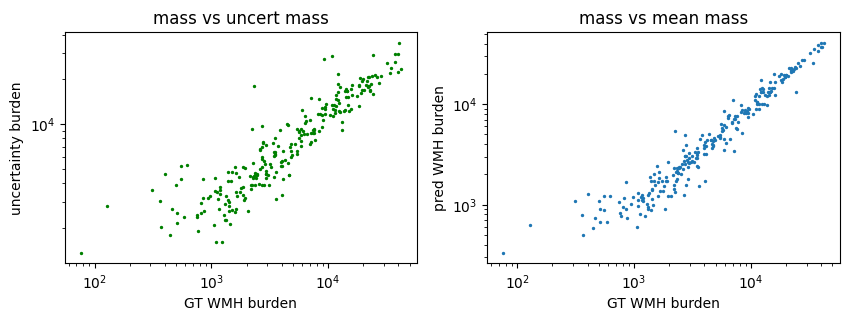

In [59]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.scatter(wmh_mass, uncert_mass, c='g', s=2)
plt.xlabel("GT WMH burden")
plt.ylabel("uncertainty burden")
plt.xscale('log')
plt.yscale('log')
plt.title("mass vs uncert mass")

plt.subplot(1,2,2)
plt.scatter(wmh_mass, mean_mass, s=2)
plt.xlabel("GT WMH burden")
plt.ylabel("pred WMH burden")
plt.xscale('log')
plt.yscale('log')
plt.title("mass vs mean mass");
plt.savefig("mass_and_uncert_burden_vs_GT")

**NOTE**: okay so the mean segmentation mass on the training data is much tighter, lower variance predictor of the target, which we would expect. The uncertainty maps have a greater variance, but the nice thing here is that
actually, we see that the mass is generally predictable from predicting the wmh mass. Now we want to see if the uncertainty variance is predicted by something else.

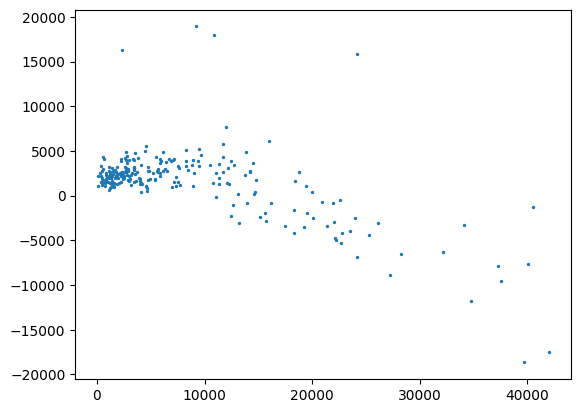

In [60]:
plt.scatter(wmh_mass, uncert_mass - mean_mass, s=2)
# plt.xscale('log')
# plt.yscale('log')

**Note**: so we see that the mean mass can be bigger than the uncertainty mass, and the larger the mass, the more of the lesion that is not edge, and so more of the lesion is less certain, so we need to add the lesion to the uncertainty...

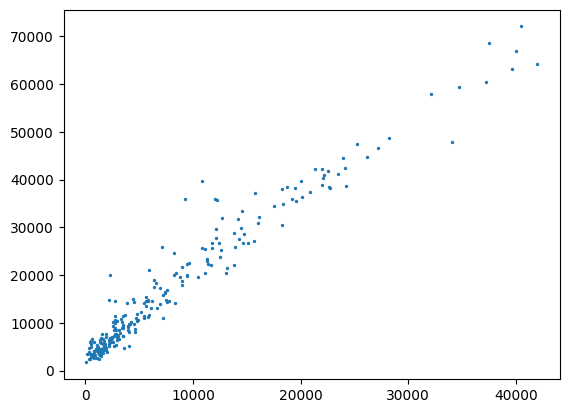

In [61]:
plt.scatter(wmh_mass, uncert_mass + mean_mass, s=2)

**Note**: BUT we can't just add them, together, as again that is just going to be further away when the volume is bigger, the uncertainty is bigger when there is more volume. So, maybe we should use the uncertainty weighted by the total volume in some way

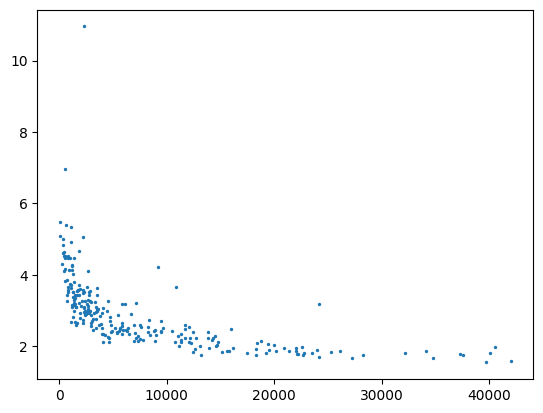

In [62]:
plt.scatter(wmh_mass, (uncert_mass+mean_mass)/(mean_mass), s=2)

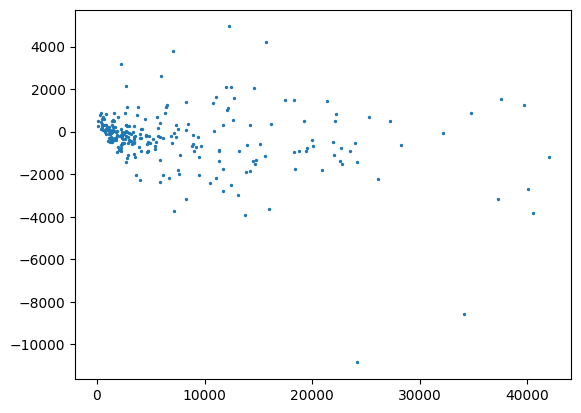

In [63]:
plt.scatter(wmh_mass, mean_mass - wmh_mass, s=2)
# plt.xscale('log')
# plt.yscale('log')

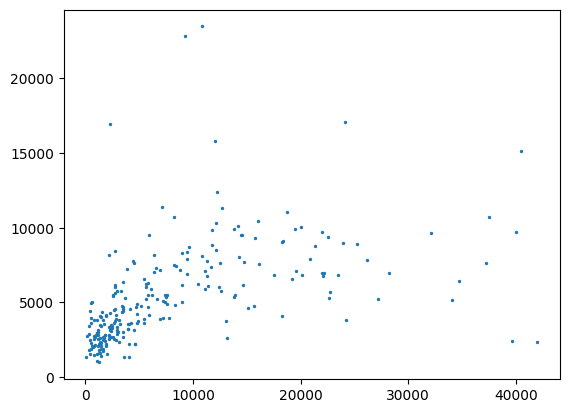

In [64]:
plt.scatter(wmh_mass, uncert_mass - (wmh_mass * 0.5), s=2)

**Note**: but again with this ratio, we have a bias, now bias the low volumes, we see that for low volumes we would be massively overestimating the damage

### uncertainty orred with wmh mean * max ent
given the plots above, we need to be careful about how we are using the uncertianty maps.
we can try orring with (uncert map) | (wmh segmentation * ~0.7) and then plot this - wmh gt * 0.7 see what kind of line we get.
or just use the uncertianty maps as is

remember to focus on what maria wants, e.g does higher volume than in the prediction suggest identifying where there is stroke, or some other variable

try PCA on all teh variables + my uncertainty metric when I get it.

In [65]:
import math
max_ent = -math.log(0.5)
max_ent

0.6931471805599453

In [66]:
dmg_maps = []
for i in tqdm(range(len(ent_maps)), position=0, leave=True):
    umap = ent_maps[i].cuda().clone()
    umap[means[i].cuda().argmax(dim=1) == 1] = max_ent
    dmg_maps.append(umap.cpu())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:02<00:00, 91.06it/s]


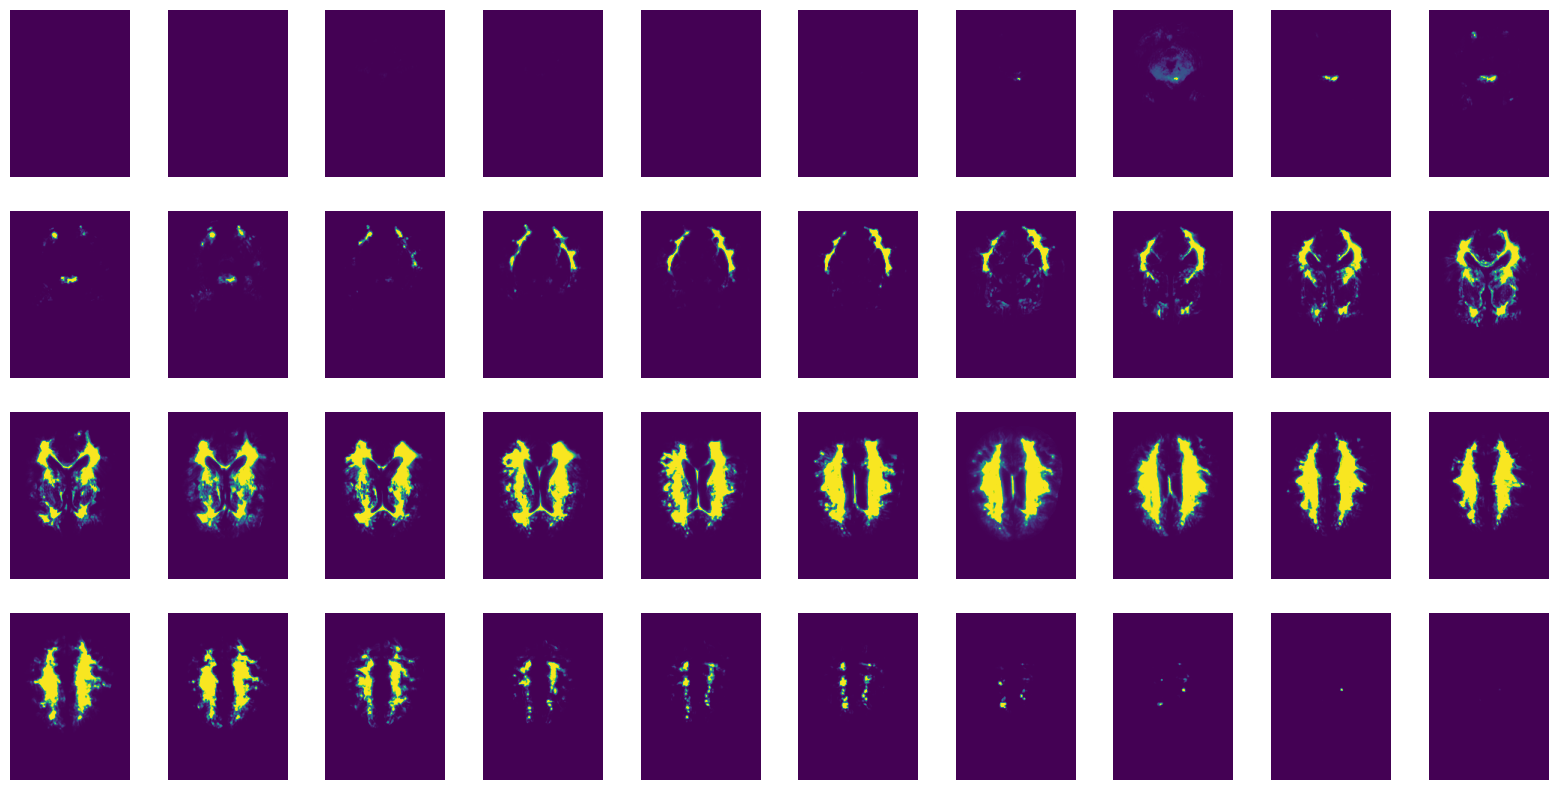

In [67]:
# plot the entropy map for the first brain scan all slices
plt.figure(figsize=(20, 10))
for i, img in enumerate(dmg_maps[0]):
    plt.subplot(4, 10, i+1)
    plt.imshow(img, vmin=0, vmax=0.7)
    plt.axis('off')

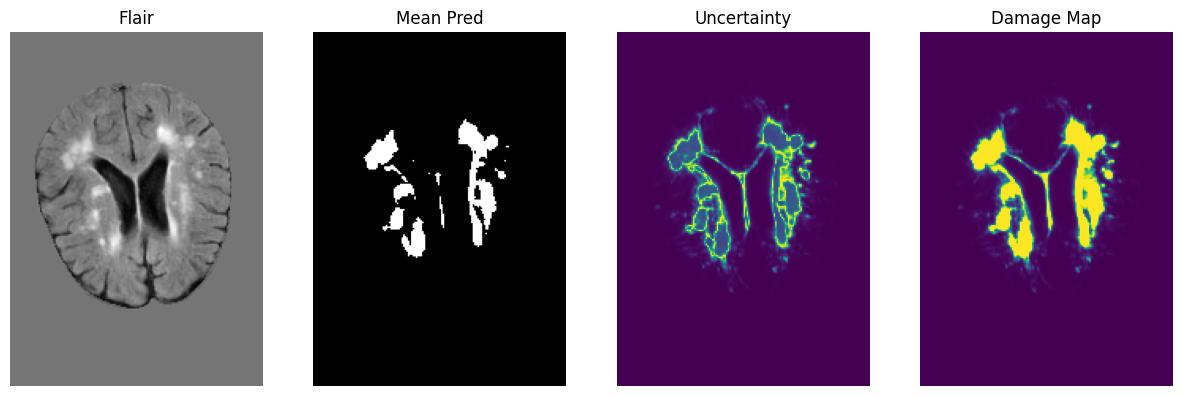

In [68]:
rows = 1
cols = 4
i = 1

plt.figure(figsize=(15, 5))
scan_id = 8
slice_id = 25
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
i = plot_subimg(means[scan_id][slice_id].argmax(dim=0), rows=rows, cols=cols, i=i, title='Mean Pred')
i = plot_subimg(ent_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, cmap=None, title='Uncertainty')
i = plot_subimg(dmg_maps[scan_id][slice_id], rows=rows, cols=cols, i=i, cmap=None, title='Damage Map')


plt.savefig("damage_map.png")

In [69]:
# lets just start with total uncertainty mass and wmh mass
dmg_mass = []
mean_dmg_mass = []
for i, (x, y, values) in enumerate(tqdm(dataset, position=0, leave=True)):
    # compute sum where we give the mean pred maximum entropy
    dmg_mass.append(dmg_maps[i].cuda().sum().cpu().item())
    mean_dmg_mass.append(mean_mass[i] * max_ent)
    
    
dmg_mass = torch.Tensor(dmg_mass)
mean_dmg_mass = torch.Tensor(mean_dmg_mass)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 597.24it/s]


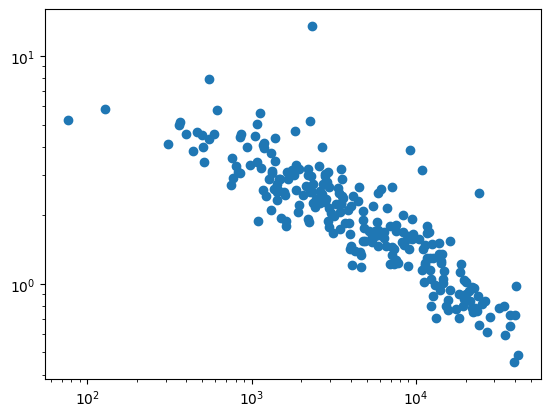

In [70]:
plt.scatter(wmh_mass, (dmg_mass - mean_dmg_mass)/mean_dmg_mass)
plt.yscale('log')
plt.xscale('log')

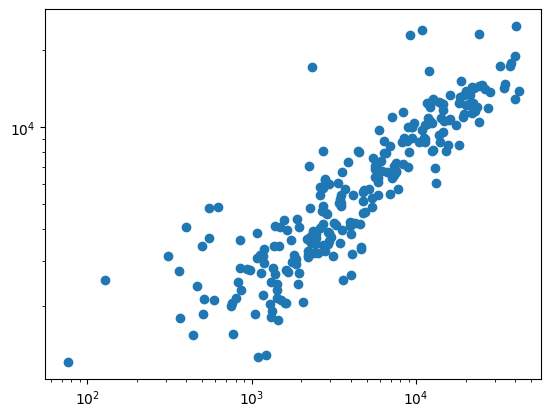

In [71]:
plt.scatter(wmh_mass, (dmg_mass - mean_dmg_mass))
plt.yscale('log')
plt.xscale('log')

In [72]:
pred = means[0].cuda().clone().argmax(dim=1).unsqueeze(1).type(torch.float32)
pred.shape 

torch.Size([40, 1, 224, 160])

### Computing umap metrics relative to surface area

In [73]:
class BinaryEdgeDetector2d():
    def __init__(self):
        l = torch.nn.Conv2d(1, 2, kernel_size=3, bias=False, padding=1)
        k = torch.Tensor([-1,-2,-1,0,0,0,1,2,1]).reshape((3, 3)).T
        l.weight.data[0][0] = k
        l.weight.data[1][0] = (k*-1).T
        l = l.cuda()
        self.l = l
        
    def __call__(self, x):
        x = x.cuda()
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        if x.shape[1] > 1:
            raise ValueError("edge detector expects a 1 channel binary mask")
        x = x.type(torch.float32)
        
        with torch.no_grad():
            edge = self.l(x)
            edge = edge.abs()
            edge = (edge[:,0] > 0) | (edge[:,1] > 0)
            edge = edge.cpu()
            return edge

In [74]:
edge_detector = BinaryEdgeDetector2d()
surface_area = []
for m in tqdm(means, position=0, leave=True):
    surface_area.append(edge_detector(m.cuda().argmax(dim=1)).sum().cpu().item())
    
surface_area = torch.Tensor(surface_area)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 167.88it/s]


/home/s2208943/miniconda3/envs/uq/lib/python3.10/site-packages/matplotlib/collections.py:1084: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


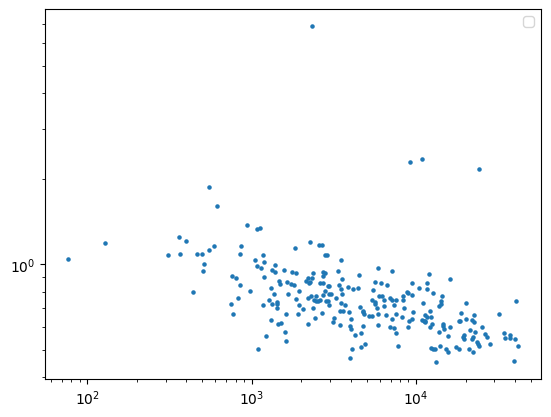

In [75]:
color = None#clin_values['sbjGroup'].values
scatter = plt.scatter(wmh_mass, (dmg_mass - mean_dmg_mass)/surface_area, c=color, label=color, s=5)
plt.yscale('log')
plt.xscale('log')
plt.legend(*scatter.legend_elements())


In [76]:
len(dmg_mass)

250

In [77]:
clin_values['sbjGroup'].values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

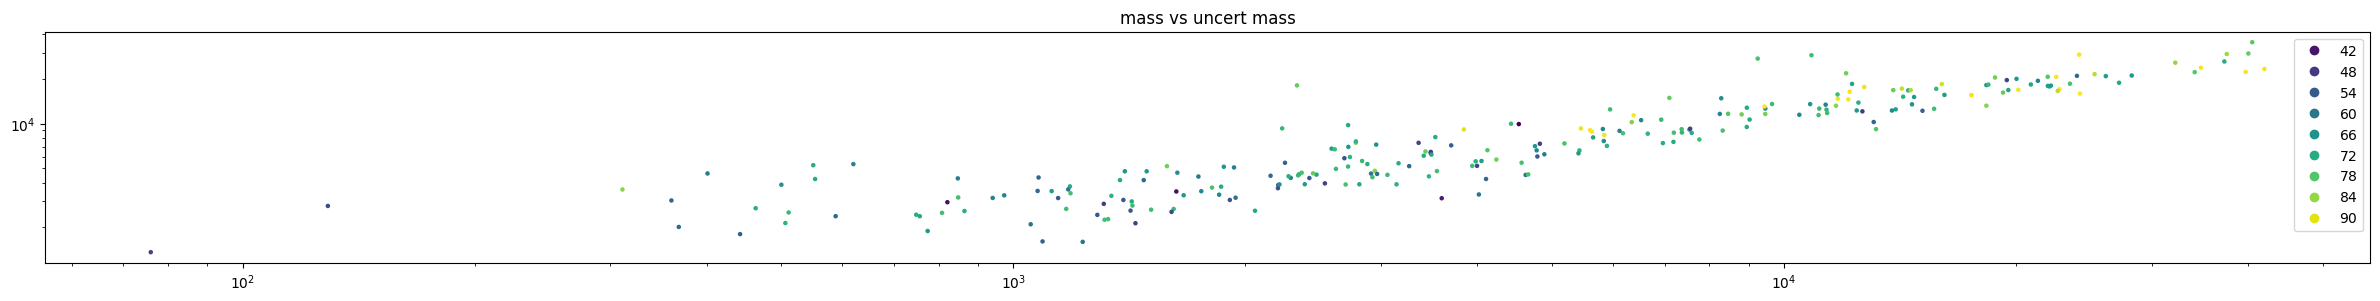

In [78]:
plt.figure(figsize=(30, 3))
color = clin_values['age'].values
scatter = plt.scatter(wmh_mass, uncert_mass, c=color, s=5, label=color)
plt.xscale('log')
plt.yscale('log')
plt.title("mass vs uncert mass")
plt.legend(*scatter.legend_elements())

### Considering the slice by slice effect
The increase in uncertainty at a specific slice / set of slices may be overshadowed by the overall volume
so instead, I could look at per-slice behaviour?
I could look at the distribution over the slices of ratio of dmg to the mean or surface area...
or I could store the maximum difference per slice, this could be an interesting analysis... (then you would likely capture the highest uncertainty at the slice where the
stroke lesion is most present...)

**NOTE**: also, remembre the image (in val set) where the model segments a 'hook' shape in the top right hand side, but misses much of the lesion on both sides middle of the brain. There is an image like this in the validation data that doesn't have these lesions it seems also... so perhaps it is a common shape and the model has overfitted to it in some way?

In [79]:
means[0].shape, ent_maps[0].shape

(torch.Size([40, 2, 224, 160]), torch.Size([40, 224, 160]))

In [80]:
ent_maps[0].cuda().sum(dim=(1,2)).shape

torch.Size([40])

In [81]:
# right, so slice by slice effects. one thing we could do is compute the maximum difference divided by the surface area in that slice.
# also the intensity damage score that maria uses I need to look at this....

slice_dmgs = []
max_slice_dmgs = []

for i in tqdm(range(len(means)), position=0, leave=True):
    m = means[i].cuda().argmax(dim=1)
    m_mass = m.sum(dim=(1,2)) * max_ent
    d_mass = dmg_maps[i].cuda().sum(dim=(1,2))
    sa = edge_detector(m).sum(dim=(1,2)).cuda()
    
    # per slice differences
    slice_diff = (d_mass - m_mass) / sa
    slice_diff[slice_diff == torch.inf] = 0
    slice_diff = slice_diff.cpu()
    
    slice_dmgs.append(slice_diff)
    max_slice_dmgs.append(slice_diff.max().item())


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:01<00:00, 138.02it/s]


In [82]:
slice_dmg_ratio_variances = [sds.var() for sds in slice_dmgs]

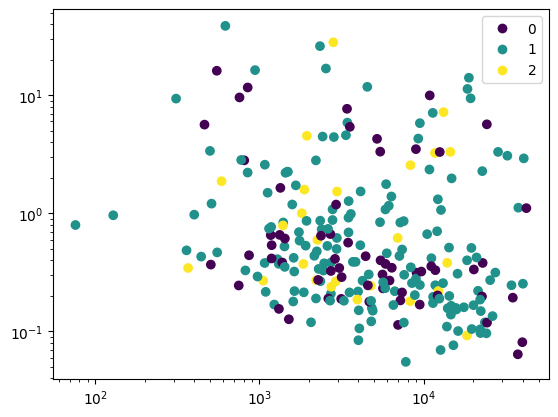

In [83]:
color = clin_values['sbjGroup'].values
scatter = plt.scatter(wmh_mass, slice_dmg_ratio_variances, c=color, label=color)
plt.xscale('log')
plt.yscale('log')
plt.legend(*scatter.legend_elements())

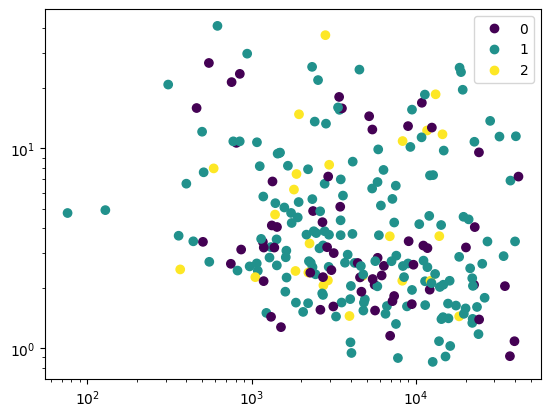

In [84]:
color = clin_values['sbjGroup'].values
scatter = plt.scatter(wmh_mass, max_slice_dmgs, c=color, label=color)
plt.xscale('log')
plt.yscale('log')
plt.legend(*scatter.legend_elements())

### looking at the difference between the confidence and the ent map
We can see clearly here that there is a possiblity for the ent_map to be highlighting extra information even when the damage score
is just using confidence...

Text(0.5, 1.0, 'dmg map')

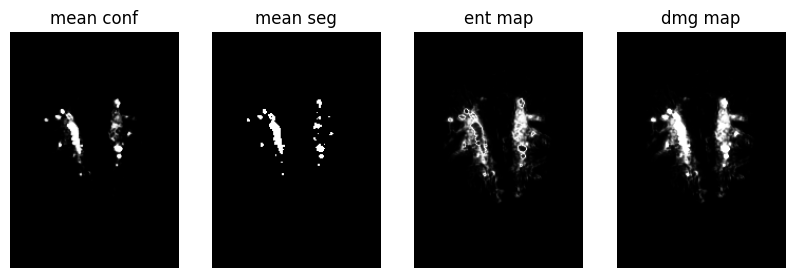

In [85]:
pos = 8
slice_id = 30
plt.figure(figsize=(10, 5))
plt.subplot(1,4,1)
plt.imshow(torch.nn.functional.softmax(means[pos], dim=1)[slice_id, 1], cmap='gray'); plt.axis('off'); plt.title("mean conf")
plt.subplot(1,4,2)
plt.imshow(torch.nn.functional.softmax(means[pos], dim=1)[slice_id, 1] > 0.5, cmap='gray'); plt.axis('off'); plt.title("mean seg")
plt.subplot(1,4,3)
plt.imshow(ent_maps[pos][slice_id], cmap='gray'); plt.axis('off'); plt.title("ent map")
plt.subplot(1,4,4)
plt.imshow(dmg_maps[pos][slice_id], cmap='gray'); plt.axis('off'); plt.title("dmg map")

### Looking at the output of fast results (used for computing damage score)

In [173]:
import torchvision as tv
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img
from natsort import natsorted
import nibabel as nib
from collections import defaultdict

In [103]:
fast_folder = "/home/s2208943/ipdis/data/preprocessed_data/Ed_fast_WM_masks/"

In [227]:
# output of fast results:
# we have to resample the image first
fnames = [name for name in natsorted(os.listdir(fast_folder)) if (".nii.gz" in name and "_T1_BET_" in name and ("pveseg" in name or "pve_2" in name))]
fnames = natsorted(fnames)

# the old way that I was loading the images, its bad because the resampling isn't done so the masks don't line up!
# imgs = []
# # this takes a couple of minutes as it is loading from the dfs
# for name in tqdm(fnames, position=0, leave=True):
#      imgs.append(np.array(nib.load(fast_folder+name).dataobj))

In [90]:
# this loop takes a while as its loading from disk and resampling
# it takes around 11 minutes

cropper = tv.transforms.CenterCrop((224, 160))

def load_fast_output(file, slices):
    timg = resample_and_return(file, is_label=True)
        
    # interpolate the channel number and centre crop
    timg = torch.Tensor(timg)
    timg = torch.nn.functional.interpolate(timg.unsqueeze(0).unsqueeze(0), (slices, *timg.shape[1:])).squeeze()
    timg = cropper(timg.view((1, 1, *timg.shape))).squeeze()
    
    return timg



In [91]:
# individual example
pos = 8
ID = clin_values.iloc[pos]['ID']
num_slices = dataset[pos][0].shape[1]

sel_files = [f for f in natsorted(os.listdir(fast_folder)) if ID in f and "_T1_BET_" in f]

In [92]:
individual_fast_examples = [load_fast_output(fast_folder + f, num_slices) for f in sel_files]

In [93]:
sel_files

['CVD170_T1_BET_mixeltype.nii.gz',
 'CVD170_T1_BET_pve_0.nii.gz',
 'CVD170_T1_BET_pve_1.nii.gz',
 'CVD170_T1_BET_pve_2.nii.gz',
 'CVD170_T1_BET_pveseg.nii.gz',
 'CVD170_T1_BET_seg.nii.gz']

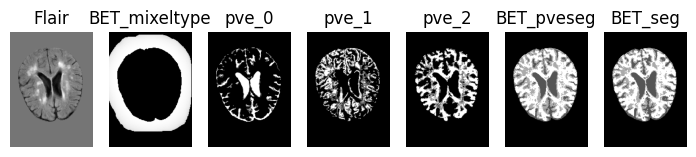

In [94]:
slice_id = 25
scan_id = pos
i = 1
rows = 1
cols = 8
plt.figure(figsize=(10, 3))
i = plot_subimg(dataset[scan_id][0][0][slice_id], rows=rows, cols=cols, i=i, title='Flair')
for j, img in enumerate(individual_fast_examples):
    i = plot_subimg(img[slice_id], rows=rows, cols=cols, i=i, title="_".join(sel_files[j].split(".")[0].split("_")[-2:]))

Ask maria about this?


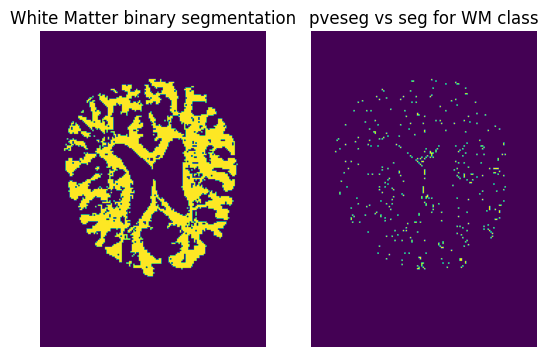

In [95]:
print("Ask maria about this?")
plt.subplot(1,2,1)
plt.imshow(individual_fast_examples[-2][slice_id] == 3); plt.axis('off'); plt.title("White Matter binary segmentation")
plt.subplot(1,2,2)
plt.imshow((individual_fast_examples[-2][slice_id] == 3) != (individual_fast_examples[-1][slice_id] == 3)); plt.axis('off'); plt.title("pveseg vs seg for WM class");

***NOTE:*** so, I can use the binary segmentation, use pveseg == 2, or I can use the WM probability map. Lets look at what the flair * these values would look like
(and then what the flair * confidence map, * the ent map, * the damage map and * the hard mean segmentation would look like.
One thing I can also try is setting a baseline threshold for the uncertianty (cutting off anything outside that uncertainty), otherwise there will be a lot of voxels at low volume adding in to the uncertianty, (I should also set it to zero outside the mask I guess.)

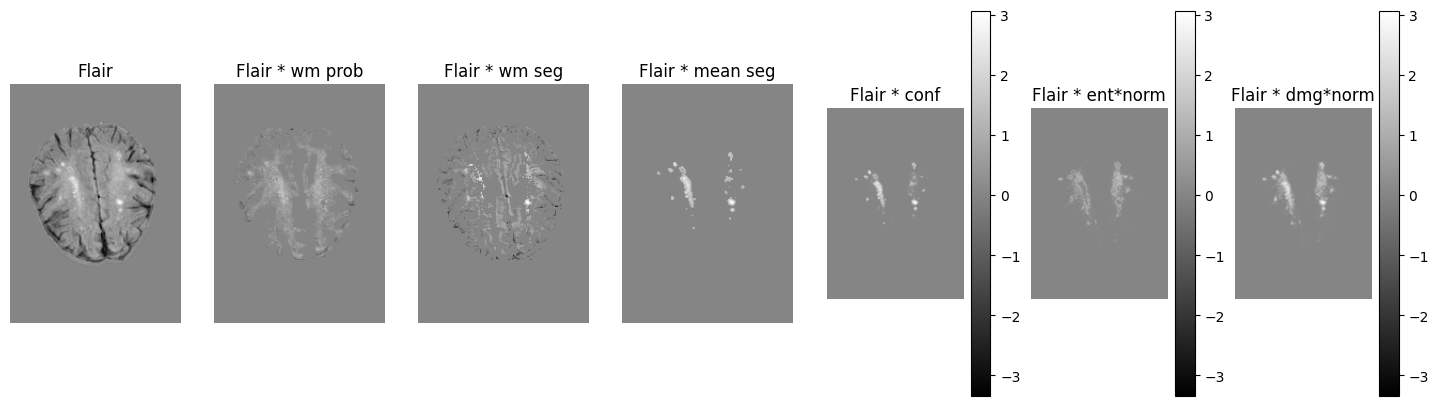

In [96]:
rows = 1
cols = 7
i = 1
scan_id = 8
slice_id = 30


plt.figure(figsize=(18, 5))
# flair
flair = dataset[scan_id][0][0][slice_id]
vmin = flair.min()
vmax = flair.max()
i = plot_subimg(flair, rows=rows, cols=cols, i=i, title='Flair', vmin=vmin, vmax=vmax)

# flair * fast wm probability distribution
i = plot_subimg(flair * individual_fast_examples[3][slice_id], rows=rows, cols=cols, i=i, title='Flair * wm prob', vmin=vmin, vmax=vmax)

# flair * fast wm hard seg
i = plot_subimg(flair * (individual_fast_examples[-1][slice_id]==2), rows=rows, cols=cols, i=i, title='Flair * wm seg', vmin=vmin, vmax=vmax)

# flair * wm mean seg conf (note that the output between the two classes is not entirely the same)
i = plot_subimg(flair * means[scan_id].argmax(dim=1)[slice_id], rows=rows, cols=cols, i=i, title='Flair * mean seg', vmin=vmin, vmax=vmax)

# flair * the mean conf
i = plot_subimg(flair * torch.nn.functional.softmax(means[scan_id], dim=1)[slice_id, 1], rows=rows, cols=cols, i=i, title='Flair * conf', vmin=vmin, vmax=vmax)
plt.colorbar()

# flair * the ent map
ent_norm_factor = 1/max_ent
i = plot_subimg(flair * (ent_maps[scan_id][slice_id]*ent_norm_factor), rows=rows, cols=cols, i=i, title='Flair * ent*norm', vmin=vmin, vmax=vmax)
plt.colorbar()

# flair * dmg map
i = plot_subimg(flair * (dmg_maps[scan_id][slice_id]*ent_norm_factor), rows=rows, cols=cols, i=i, title='Flair * dmg*norm', vmin=vmin, vmax=vmax)
plt.colorbar()

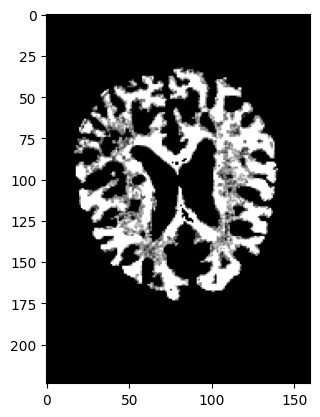

In [97]:
plt.imshow(individual_fast_examples[3][25], cmap='gray');
# example of the white matter segmentation

In [98]:
individual_fast_examples[4].min()

tensor(0.)

### Converting the uncertainty maps back to the original shape for maria

In [174]:
import SimpleITK as sitk
from twaidata.MRI_preprep.resample import resample_and_return, get_resampled_img

In [132]:
# individual example
pos = 8
ID = clin_values.iloc[pos]['ID']
num_slices = dataset[pos][0].shape[1]

sel_files = [f for f in natsorted(os.listdir(fast_folder)) if ID in f and "_T1_BET_" in f]

In [213]:
example_wm = fast_folder + sel_files[3]
orig_img = sitk.ReadImage(example_wm)
orig_spacing = orig_img.GetSpacing()
orig_shape = sitk.GetArrayFromImage(orig_img).shape
orig_channels = orig_shape[0]
sel_files[3]

prepped_img = ent_maps[pos]
prepped_channels = prepped_img.shape[0]

In [214]:
orig_spacing

(0.9374880194664001, 0.9375, 4.000056266784668)

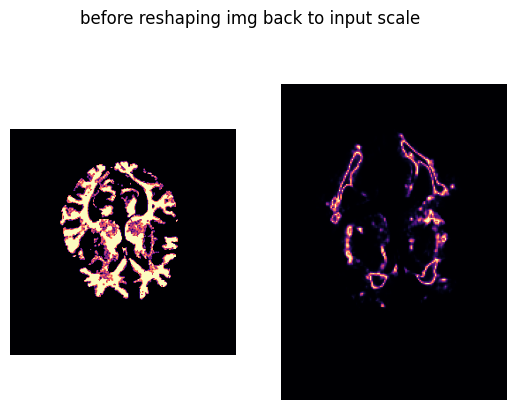

In [215]:
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(orig_img)[channels//2], cmap='magma'); plt.axis('off')
plt.subplot(1,2,2)

plt.imshow(prepped_img[prepped_channels//2], cmap='magma'); plt.axis('off')
plt.suptitle("before reshaping img back to input scale");

In [229]:
def reverse_resampling_of_image(wm_file, img_to_resample, save_location=None, name=None):
    # load the wm file that is in the target shape  and sampling
    orig_img = sitk.ReadImage(wm_file)
    orig_spacing = orig_img.GetSpacing()
    orig_shape = sitk.GetArrayFromImage(orig_img).shape
    
    # get the un padded shape of the resampled version of the original image shape
    timg = resample_and_return(wm_file, is_label=True)
    timg = torch.Tensor(timg)
    h_orig, w_orig = timg.shape[1:]
    
    # perform padding
    h, w = img_to_resample.shape[1:]
    h_diff = (h_orig - h) // 2
    w_diff = (w_orig - w) // 2
    new_img = torch.nn.functional.pad(img_to_resample, pad=(w_diff, w_diff, h_diff, h_diff), mode='constant', value=0)
    
    # resample
    new_img = sitk.GetImageFromArray(new_img)
    new_img.SetSpacing([1., 1., 3.]) # the spacing that was used as the out spacing during the preprocessing stage
    # we need to tell the sitk image what the true spacing prior to resampling is because it doesn't know as its just taken from a numpy array
    new_img = get_resampled_img(new_img, is_label=True, out_spacing=orig_spacing)
    
    if save_location:
        sitk.WriteImage(new_img, f"{save_location}{name}.nii.gz")
    else:
        return new_img

In [230]:
new_img = reverse_resampling_of_image(fast_folder + sel_files[3], ent_maps[pos])

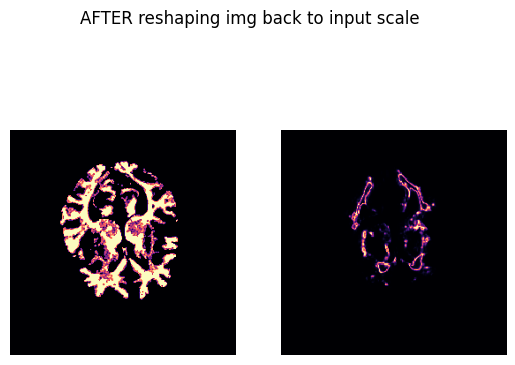

In [231]:
plt.subplot(1,2,1)
plt.imshow(sitk.GetArrayFromImage(orig_img)[channels//2], cmap='magma'); plt.axis('off')
plt.subplot(1,2,2)

plt.imshow(sitk.GetArrayFromImage(new_img)[channels//2], cmap='magma'); plt.axis('off')
plt.suptitle("AFTER reshaping img back to input scale");

In [233]:
max_ent = -math.log(0.5)
max_ent

0.6931471805599453

In [234]:
1/max_ent

1.4426950408889634

In [239]:
torch.nn.functional.softmax(means[0], dim=1)[:,1].shape

torch.Size([40, 224, 160])

In [240]:
# for pos in tqdm(range(len(dataset)), position=0, leave=True):
#     ID = clin_values.iloc[pos]['ID']
#     wm_path = fast_folder + ID + "_T1_BET_pve_2.nii.gz"
#     result_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData_umaps/"
    
#     ent = ent_maps[pos] / max_ent
#     comb = dmg_maps[pos] / max_ent
#     seg = torch.nn.functional.softmax(means[pos], dim=1)[:,1]
    
#     reverse_resampling_of_image(wm_path, ent, result_dir, ID + "_ent_map")
#     reverse_resampling_of_image(wm_path, comb, result_dir, ID + "_comb_map")
#     reverse_resampling_of_image(wm_path, seg, result_dir, ID + "_seg_map")
    
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [08:49<00:00,  2.12s/it]


### Loading the fast images for each scan
need to load the pve_2 and the pve_seg files (but need to ask maria the difference between pve_seg and seg)

In [241]:
fast_imgs = defaultdict(lambda: {})

for pos in tqdm(range(len(dataset)), position=0, leave=True):
    # get target image named
    ID = clin_values.iloc[pos]['ID']
    locs = [i for i in range(len(fnames)) if ID in fnames[i]]
    selected_fnames = [fnames[i] for i in locs]
    
    target_shape = dataset[pos][0][0].shape
    num_slices = target_shape[0]
    
    for name in selected_fnames:
        # resample the image (should have done this during the preprocess)
        timg = load_fast_output(fast_folder + name, num_slices)
        
        fast_imgs[ID][name] = timg

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [01:19<00:00,  3.13it/s]


In [242]:
pos = 8
ID = clin_values.iloc[pos]['ID']
flair = dataset[pos][0][0]

imgs = list(fast_imgs[ID].values())
keys = list(fast_imgs[ID].keys())

In [243]:
keys

['CVD170_T1_BET_pve_2.nii.gz', 'CVD170_T1_BET_pveseg.nii.gz']

### Computing the damage scores in various guises, normalized and un-normalized

when computing the damage score, I could threshold the uncertainty, or I could try multiplying the intensities by the uncertainty threshold, those that are outside the mean segmentaion..?
Or, I could take any pixel with uncertainty > 0.01 and multiply it by the uncertainty when contributing it to the damage score in some way...? Interesting... I need to ensure the uncertainty damage score is always greater than the WMH damage score?
or I could try one where the uncertainty damage score can be theoretically less?

In [244]:
max_ent

0.6931471805599453

In [249]:
# new damage score functions
def normalize01_scale(img):
    return (img - img.min()) / (img.max() - img.min())

def damage_score_thresholded(flair, wmh_mask, wm_mask, brain_mask, normalize_flair=True):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_voxels = flair[(wm_mask == 1) & (wmh_mask != 1) & (brain_mask==1)]
    wmh_voxels = flair[(wmh_mask == 1) & (brain_mask==1)]
    
    I_wm = wm_voxels.mean().item()
    I_wmh = wmh_voxels.mean().item()
    
    vol_wm = wm_voxels.shape[0]
    vol_wmh = wmh_voxels.shape[0]
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm))
    
        return damage
    except:
        return torch.nan
        

def damage_score_probabilistic(flair, wmh_map, wm_map, brain_mask, normalize_flair=True, min_threshold=0.01, bias=1):
    if normalize_flair:
        flair = normalize01_scale(flair)
        
    wm_prob_weighted = (wm_map * flair)[(wm_map > min_threshold) & (wmh_map < min_threshold) & (brain_mask==1)]
    wmh_prob_weighted = (wmh_map * flair)[(wmh_map > min_threshold) & (brain_mask==1)]
    
    I_wm = wm_prob_weighted.mean()
    I_wmh = wmh_prob_weighted.mean()
    
    vol_wm = wm_map.sum()
    vol_wmh = wmh_map.sum()
    
    try:
        damage = ((I_wmh - I_wm) / I_wm) * (vol_wmh / (vol_wmh + vol_wm)) + bias
    
        return damage.item()
    except:
        return torch.nan
    
    return damage

In [250]:
torch.nan

nan

In [323]:
# the damage scores that we can compute:
# threshold the uncertainty at different levels, 0.01, 0.1, 0.2, 0.3, 0.4
# or a different damage metric where we increase the volume of the WMH using the uncertainty map
# we don't change the IWMH (as it highlights a greater background area which has lower uncertainty
# but it also highlights it with different levels of uncertainty which we want to be sensitive too

# okay, to build all my damage scores, I have the following to do:
# build the filters for each image
# do the 5 types of damage score.
# compute this for each image. Then we are ready to get modelling.

uncert_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
min_prob_thresh = 0.3
bias=0

def generate_damage_scores(uncert_thresholds, normalize):
    rows = []

    for pos in tqdm(range(len(dataset)), position=0, leave=True):
        row = {}
        
        # get target image named
        ID = clin_values.iloc[pos]['ID']
        row['ID'] = ID

        flair = dataset[pos][0][0].cuda()
        mask = dataset[pos][0][1].cuda()
        wmh = means[pos].cuda()
        
        # zero the dmg and ent maps outside the mask (I forgot to do it earlier oops)
        # and normalize them to 0-1 entropy range
        ent_normalizer = 1/max_ent
        dmg_map = dmg_maps[pos].cuda() * mask * ent_normalizer
        ent_map = ent_maps[pos].cuda() * mask * ent_normalizer

        # build the 'nawm' (as maria is defining it?) mask options
        fast_map = fast_imgs[ID]
        wm_map = fast_map[ID + "_T1_BET_pve_2.nii.gz"].cuda()
        wm_seg = fast_map[ID + "_T1_BET_pveseg.nii.gz"].cuda() == 3 # 0 = fast brain mask (is it different to bet?), 1 = csf, 2 = gray, 3 = white

        # compute the soft damage scores for mean conf, umap, dmg_map,
        row["mean_dmg"] = damage_score_probabilistic(flair, torch.nn.functional.softmax(wmh, dim=1)[:,1], wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        row["ent_dmg"] = damage_score_probabilistic(flair, ent_map, wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        row["comb_dmg"] = damage_score_probabilistic(flair, dmg_map, wm_map, mask, normalize_flair=normalize, min_threshold=min_prob_thresh, bias=bias)
        
        # hard damage score for mean
        row["mean_thresh_dmg"] = damage_score_thresholded(flair, wmh.argmax(dim=1), wm_seg, mask, normalize_flair=normalize)
        
        # hard damage score for uncertainty maps at varying thresholds
        for t in uncert_thresholds:
            row[f"ent>{t}_thresh_dmg"] = damage_score_thresholded(flair, ent_map > (t*ent_normalizer), wm_seg, mask, normalize_flair=normalize)
            row[f"comb>{t}_thresh_dmg"] = damage_score_thresholded(flair, dmg_map > (t*ent_normalizer), wm_seg, mask, normalize_flair=normalize)
        
        rows.append(row)
    
    return rows

In [275]:
dmg_rows = generate_damage_scores(uncert_thresholds, normalize=False)
dmg_df = pd.DataFrame(dmg_rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 38.66it/s]


In [324]:
dmg_norm_rows = generate_damage_scores(uncert_thresholds, normalize=True)
dmg_norm_df = pd.DataFrame(dmg_norm_rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:06<00:00, 41.40it/s]


In [325]:
dmg_norm_df

,ID,mean_dmg,ent_dmg,comb_dmg,mean_thresh_dmg,ent>0.1_thresh_dmg,comb>0.1_thresh_dmg,ent>0.2_thresh_dmg,comb>0.2_thresh_dmg,ent>0.3_thresh_dmg,comb>0.3_thresh_dmg,ent>0.4_thresh_dmg,comb>0.4_thresh_dmg,ent>0.5_thresh_dmg,comb>0.5_thresh_dmg
0,CVD064,0.093463,-0.004565,0.114284,0.080589,0.090527,0.106620,0.054863,0.101601,0.036759,0.097781,0.027545,0.094515,0.020424,0.091295
1,CVD092,0.001529,-0.001529,0.002061,0.001248,0.002732,0.002898,0.001657,0.002108,0.001114,0.001794,0.000713,0.001597,0.000492,0.001487
2,CVD090,0.003493,-0.001675,0.004649,0.002993,0.006183,0.006796,0.004141,0.005288,0.002836,0.004533,0.002013,0.004073,0.001412,0.003742
3,CVD237,0.053944,-0.011342,0.059328,0.046316,0.043473,0.062149,0.023836,0.058317,0.017106,0.055765,0.012646,0.053581,0.009272,0.051713
4,CVD134,0.013629,-0.002611,0.017566,0.011281,0.015740,0.019540,0.010224,0.016633,0.007425,0.015103,0.005633,0.014081,0.004122,0.013304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,CVD236,0.005220,-0.006146,0.005051,0.006295,0.014678,0.015423,0.009812,0.012089,0.006866,0.010289,0.004983,0.009194,0.003523,0.008308
246,CVD279,0.001455,-0.011932,-0.007345,0.001939,0.011112,0.011352,0.005351,0.005997,0.002968,0.003944,0.001813,0.003019,0.001241,0.002648
247,CVD132,0.000686,-0.007204,-0.004094,0.001277,0.007522,0.007540,0.004266,0.004546,0.002723,0.003210,0.001734,0.002461,0.001096,0.001982
248,CVD268,0.067479,-0.007522,0.076946,0.058441,0.059763,0.079303,0.034112,0.074304,0.022898,0.070898,0.016904,0.068108,0.012293,0.065550


In [278]:
dmg_norm_df['comb_dmg'].max()

1.2323012351989746

In [279]:
dmg_norm_df

,ID,mean_dmg,ent_dmg,comb_dmg,mean_thresh_dmg,ent>0.1_thresh_dmg,comb>0.1_thresh_dmg,ent>0.2_thresh_dmg,comb>0.2_thresh_dmg,ent>0.3_thresh_dmg,comb>0.3_thresh_dmg,ent>0.4_thresh_dmg,comb>0.4_thresh_dmg,ent>0.5_thresh_dmg,comb>0.5_thresh_dmg
0,CVD064,1.093463,0.995435,1.114285,0.080589,0.090527,0.106620,0.054863,0.101601,0.036759,0.097781,0.027545,0.094515,0.020424,0.091295
1,CVD092,1.001529,0.998471,1.002061,0.001248,0.002732,0.002898,0.001657,0.002108,0.001114,0.001794,0.000713,0.001597,0.000492,0.001487
2,CVD090,1.003493,0.998325,1.004649,0.002993,0.006183,0.006796,0.004141,0.005288,0.002836,0.004533,0.002013,0.004073,0.001412,0.003742
3,CVD237,1.053944,0.988658,1.059328,0.046316,0.043473,0.062149,0.023836,0.058317,0.017106,0.055765,0.012646,0.053581,0.009272,0.051713
4,CVD134,1.013629,0.997389,1.017566,0.011281,0.015740,0.019540,0.010224,0.016633,0.007425,0.015103,0.005633,0.014081,0.004122,0.013304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,CVD236,1.005220,0.993854,1.005051,0.006295,0.014678,0.015423,0.009812,0.012089,0.006866,0.010289,0.004983,0.009194,0.003523,0.008308
246,CVD279,1.001455,0.988068,0.992655,0.001939,0.011112,0.011352,0.005351,0.005997,0.002968,0.003944,0.001813,0.003019,0.001241,0.002648
247,CVD132,1.000686,0.992796,0.995906,0.001277,0.007522,0.007540,0.004266,0.004546,0.002723,0.003210,0.001734,0.002461,0.001096,0.001982
248,CVD268,1.067479,0.992478,1.076946,0.058441,0.059763,0.079303,0.034112,0.074304,0.022898,0.070898,0.016904,0.068108,0.012293,0.065550


### Building the clinscores table for linear model training

from the plots it is hard to see a clear link with stroke and excess uncertainty.
First I should look at the validation and test data combined to see how they fare.
Then fit a line to some of these plots, and record the distance away from the curve
Then, start adding the values I have computed to the clin-scores table so that we can try and fit some models with it. Look up that beta value thing.
See if we can find a linear model that takes a combination of factors and can predict these things.

**NOTE**: for doing any future analysis properly, I need to cross validate my training data, so that I have valid data to experiment with and for fitting models (so that i have each element in the test data and
I can look at the prediction scores across all the images. Important to do....

In [326]:
# adding derived fields
other_scores_df = {}
other_scores_df['ID'] = clin_values['ID'].values
other_scores_df["wmh_gt_vol"] = wmh_mass
other_scores_df["mean_vol"] = mean_mass
other_scores_df["uncert_vol"] = uncert_mass
other_scores_df["comb_vol"] = dmg_mass
other_scores_df["(comb-mean_scaled)/surface_area"] = (dmg_mass - mean_dmg_mass)/surface_area
other_scores_df["(dmg-mean_scaled)"] = dmg_mass - mean_dmg_mass
other_scores_df["max slice (comb-mean_s)/sa"] = max_slice_dmgs
other_scores_df = pd.DataFrame(other_scores_df)

In [327]:
other_scores_df

,ID,wmh_gt_vol,mean_vol,uncert_vol,comb_vol,(comb-mean_scaled)/surface_area,(dmg-mean_scaled),max slice (comb-mean_s)/sa
0,CVD064,37514.0,39047.0,29454.425781,44790.992188,0.564027,17725.673828,6.901799
1,CVD092,1091.0,962.0,1609.444580,1922.952515,0.501655,1256.144897,2.439889
2,CVD090,1614.0,1663.0,2661.671875,3210.493652,0.534908,2057.790039,2.852305
3,CVD237,22094.0,22573.0,17793.318359,27411.066406,0.490930,11764.655273,1.402436
4,CVD134,7761.0,6665.0,7822.477539,10313.692383,0.516029,5693.866211,0.893297
...,...,...,...,...,...,...,...,...
245,CVD236,4774.0,3883.0,6609.339844,7805.291504,0.676787,5113.800781,2.339532
246,CVD279,620.0,1211.0,5339.411133,5695.361328,1.597881,4855.959961,41.044975
247,CVD132,1078.0,1106.0,4337.602051,4630.878906,1.329752,3864.258057,10.734963
248,CVD268,26139.0,23902.0,20891.828125,30568.558594,0.568105,14000.955078,1.788725


In [336]:
all_dmg_scores = pd.concat([other_scores_df, dmg_norm_df], join='outer', axis=1)

In [337]:
all_dmg_scores.to_excel("CVD_dmg_scores.xlsx")

In [282]:
"""AUX FUNCTIONS"""

def convert_symbol_to_nan(df, field, symbol):
    df = df.copy()
    """
    converts all inputs conforming to 'symbol' to np.nan for the given 'field' in the 'df'
    e.g if symbol=' ' and field='totalChl' then any instances of ' ' in the 'totalChl' column will be replaced with np.nan
    """
    values = df[field].values
    locs = values == symbol
    values[locs] = np.nan
    
    df[field] = values
    
    return df

def filter_rows_with_nans(df, field, inplace=False):
    """
    removes all rows from df which have nan for the given field value
    """
    values = df[field].values
    nan_locs = np.where(np.isnan(values))[0]
    df = df.drop(nan_locs, inplace=inplace)
    df = df.reset_index(drop=True)
    
    return df
    
    
def one_hot_encode(df, field, remove_original=True):
    """computes a one hot encoding of the given field"""
    
    onehot_cols = pd.get_dummies(df[field], prefix=field)
    
    if remove_original:
        df = df.drop(columns=[field], inplace=False)
        
    df = pd.concat([df, onehot_cols], axis=1)
    
    return df
    
    

In [283]:
def preprep_clinscores(
    df,
    fields,
    inc_brain_scores=False,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'row', 'DBP':'row', 'MMSE':'col', 'relLes':'row'},
    other_fields_policy = 'row',
    relLes_default = 0,
    one_hot_fields = None,
    remove_one_hot_originals = True,
    log_fields = None,
    normalize_fields = None
    ):
    
    """
    fields: a list of fields to keep in preprocessed table.
    
    inc_brain_scores: <True, False> includes the following fields, which are otherwise missing collectively in multiple rows: PVWMH, DWMH, deepAtrophy, supAtrophy, BGPVS, CSPVS, oldLes, relLes
        if true rows missing these values are skipped
        if false, the column entirely is skipped.
    
    nan_filter_dict: {key: <'row', 'col', None>} a dictionary of field names and filter options. 
                if filter = row, rows with this field equal to Nan are ignored. if filter = col, the column is removed if there are any Nans in the column. if filter = None: do nothing.
                the same behaviour as inc_brain_scores but for specified fields.
    
    relLes_default: value to set relLes to when sbjGroup = 0 (community dwelling). relLes cannot be 1 in this case and is stored as Nan but this is unhelpful. default 0.
    
    one_hot_fields: list of field names to be converted to one hot encoding. None if no fields to be converted.
    
    remove_one_hot_originals: remove the original column that the one-hot fields were generated from.
    
    log_fields: fields converted to log form
    
    """
    df = df.copy() # ensure we don't onverwrite stuff in source df.
    
    # deal with bad field in totalChl field
    df = convert_symbol_to_nan(df, 'totalChl', ' ')
    df['totalChl'] = df['totalChl'].values.astype(np.float32)
    
    # set relLes to default value where sbjGroup = 0 and relLes is Nan
    relLes = df['relLes'].values
    relLes[(df['sbjGroup'].values == 0) & np.isnan(relLes)] = relLes_default
    df['relLes'] = relLes
    
    # select the chosen fields
    df = df[fields]
    
    # ignore the brain score fields
    if not inc_brain_scores:
        df = df.drop(columns=['PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'oldLes', 'relLes'], inplace=False)
    
    # filter fields
    keys = df.keys()
    for field, behaviour in nan_filter_dict.items():
        if field not in keys:
            continue
        if behaviour == None:
            continue
        elif behaviour == 'row':
            df = filter_rows_with_nans(df, field)
        elif behaviour == 'col':
            if np.sum(np.isnan(df[field].values)) > 0:
                df = df.drop(columns=[field], inplace=False)
        else:
            raise ValueError(f"nan_filter_dict must contain key:<'row', col', None> pairs, not {behaviour}")
    
    # one hot encoding (ignore the field if it is not present)
    keys = df.keys()
    if one_hot_fields:
        for field in one_hot_fields:
            if field in keys:
                df = one_hot_encode(df, field, remove_one_hot_originals)
                
    if other_fields_policy:
        for field in df.keys():
            if other_fields_policy == 'row':
                try:
                    df = filter_rows_with_nans(df, field)
                except:
                    print("skipping filtering col: ", field)
            elif other_fields_policy == 'col':
                if np.sum(np.isnan(df[field].values)) > 0:
                    df = df.drop(columns=[field], inplace=False)
            else:
                raise ValueError(f"other_fields_policy must be:<'row', col', None> pairs, not {other_fields_policy}")
                
    # log specific fields
    if log_fields:
        for field in log_fields:
            df[field] = np.log(df[field].values + 1e-30)
            
    if normalize_fields:
        for field in normalize_fields:
            values = df[field].values
            values = (values - np.mean(values)) / np.std(values)
            df[field] = values
            
            
    # convert relLes and oldLes to a single field
    # print(df['relLes'].values)
    # df['les'] = (df['relLes'].values * df['oldLes'].values)
    # df = df.drop(columns=['oldLes', 'relLes'], inplace=False)
            
    return df

In [284]:
print("THIS IS A CONCERNING POINT TO TALK TO MARIA ABOUT")
(clin_values.loc[clin_values['sbjGroup'] == 2])[['PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'oldLes', 'relLes']]

THIS IS A CONCERNING POINT TO TALK TO MARIA ABOUT


,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,oldLes,relLes
37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Time to start doing some linear modelling....

In [285]:
# using the non-normalized version of the damage score (which can include negative areas in the mass sum causing issues....
combined_df = pd.concat([clin_values, dmg_norm_df, other_scores_df], join='outer', axis=1)

In [307]:
# pick our dataset
wm_filter = 'wm1' # 'wm1', 'wm1+2'

df = preprep_clinscores(
    df=combined_df,
    fields=['ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_mass', 'mean_mass',
       'uncert_mass', 'dmg_mass', '(dmg-mean_scaled)/surface_area', 'max slice damages'],
    inc_brain_scores=True,
    nan_filter_dict = {'hyperlipidaemia': 'row', 'smoking':'row', 'SBP':'col', 'DBP':'col', 'MMSE':'col', 'relLes':'row', 'ICV':'row', 'totalChl': 'col', 'micrBld': 'row'},
    other_fields_policy = 'row',#'col',
    relLes_default = 0,
    one_hot_fields = ['sbjGroup', 'smoking', 'PVWMH', 'DWMH'],
    remove_one_hot_originals = False,
    log_fields = ['mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_mass', 'mean_mass',
       'uncert_mass', 'dmg_mass', '(dmg-mean_scaled)/surface_area', 'max slice damages'],
    normalize_fields = ['age', 'ICV']
)

skipping filtering col:  ID
skipping filtering col:  ID
skipping filtering col:  ID


In [308]:
df.keys()

Index(['ID', 'ID', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes', 'hypertension',
       'hyperlipidaemia', 'smoking', 'ICV', 'WMH', 'PVWMH', 'DWMH',
       'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'relLes', 'oldLes',
       'micrBld', 'mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_mass', 'mean_mass', 'uncert_mass',
       'dmg_mass', '(dmg-mean_scaled)/surface_area', 'max slice damages',
       'sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
       'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
       'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0'],
      dtype='object')

things I can try:
- not normalizing age
- not taking the log of my target fields
- try the following targets:
    - normalized damage scores
    - other filter types
    - thresholded uncertainty vs specific uncertainty
    - predicting the umap volume directly
    - predicted the scaled umap thing
    - predicting the 'worst slice' damage score
- try different versions of the uncertainty maps (variance, kernel density estimates)
- try predicting something from the uncertainty map, e.g the fazekas score, or relLes, from the uncertianty map metrics, can include all the uncertainty map metrics
- also try given the uncertainty map vs given the mean segmentation what can we predict. (does uncertainty map improve things?) Lets see.
- yeah I like the lets try predicting each different biomarker idea (given all the other biomarkers) so lets do that.
- I notice it can predict the uncertainty map damage given the true damage hmmm these values are just too close...

In [309]:
#df[f'{wm_filter}/dmg>0.4_damage'].values

In [310]:
from sklearn import linear_model
from sklearn import tree
from sklearn import svm

In [311]:
from sklearn.model_selection import train_test_split

In [312]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=9876)

In [313]:
# reg = linear_model.LinearRegression()
reg = linear_model.ARDRegression()
# reg = linear_model.Lasso(alpha=0.1)
# reg = linear_model.BayesianRidge()
# reg = tree.DecisionTreeRegressor()
# reg = svm.SVR()
# reg = linear_model.HuberRegressor(max_iter=5000)
# reg = linear_model.TheilSenRegressor(max_iter=500)

In [314]:
predict_keys = ['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'ICV',
       'BGPVS', 'CSPVS', 'oldLes', 'relLes', 'micrBld', 'sbjGroup_0', 'sbjGroup_1', 'PVWMH_0.0',
                'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0',
                'smoking_0.0', 'smoking_1.0', 'smoking_2.0', 'deepAtrophy', 'supAtrophy' ]

In [315]:
train_df.keys()

Index(['ID', 'ID', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes', 'hypertension',
       'hyperlipidaemia', 'smoking', 'ICV', 'WMH', 'PVWMH', 'DWMH',
       'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS', 'relLes', 'oldLes',
       'micrBld', 'mean_dmg', 'ent_dmg', 'comb_dmg', 'mean_thresh_dmg',
       'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
       'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
       'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
       'comb>0.5_thresh_dmg', 'wmh_gt_mass', 'mean_mass', 'uncert_mass',
       'dmg_mass', '(dmg-mean_scaled)/surface_area', 'max slice damages',
       'sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
       'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
       'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0'],
      dtype='object')

In [316]:
def train_model(columns, return_diff=False):
    X_train = train_df.drop(columns=columns)
    X_test = test_df.drop(columns=columns)

    y_train = train_df[label]
    y_test = test_df[label]
    
    reg.fit(X_train, y_train)
    
    X, y = X_test, y_test
    
    if return_diff:
        return np.abs((reg.predict(X) - y).values), X, y
    return (((reg.predict(X) - y).values)**2).mean()


rows = []
for key in predict_keys:
    clin_columns = ['sbjGroup', 'age', 'sex', 'diabetes', 'hypertension',
           'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl', 'ICV', 'WMH',
           'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy', 'BGPVS', 'CSPVS',
           'relLes', 'oldLes', 'micrBld','sbjGroup_0', 'sbjGroup_1', 'smoking_0.0', 'smoking_1.0', 'smoking_2.0',
           'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0',
           'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']

    one_hot_drop = ['sbjGroup', 'smoking', 'PVWMH', 'DWMH']

    wmh_fields = ['mean_mass', 'mean_dmg', 'mean_thresh_dmg']
    wmh_drops = []

    umap_fields = ['max slice damages', '(dmg-mean_scaled)/surface_area', 'dmg_mass', 'uncert_mass',
                   'ent_dmg', 'comb_dmg',
           'ent>0.1_thresh_dmg', 'comb>0.1_thresh_dmg', 'ent>0.2_thresh_dmg',
           'comb>0.2_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.3_thresh_dmg',
           'ent>0.4_thresh_dmg', 'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg',
           'comb>0.5_thresh_dmg']
    
    umap_drops = []#['dmg_mass', 'uncert_mass' ]

    other_drops = ['ID', 'wmh_gt_mass', 'WMH']

    label = key# '(dmg-mean_scaled)/surface_area'
    
    label_drops = ['smoking_0.0', 'smoking_1.0', 'smoking_2.0']
    if 'PVWMH' in key or 'DW' in key:
        label_drops += ['PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0']
    if 'Atrophy' in key:
        label_drops += ['deepAtrophy', 'supAtrophy']

    default_drops = [label]+label_drops+other_drops+one_hot_drop+umap_drops+wmh_drops
    
    drops = default_drops + umap_fields + wmh_fields
    result_standard = train_model(drops)
    
    drops = default_drops + umap_fields
    result_wmh = train_model(drops)
    drops = default_drops
    result_uncert = train_model(drops)

    print(f"{key}: {result_standard:.3f}, {result_wmh:.3f} {result_uncert:.3f}")
    row = {"key":key, "MSE (ClinScore)":f"{result_standard:.3f}" , "MSE (+ mean seg)": f"{result_wmh:.3f}", "MSE (+ u_map)": f"{result_uncert:.3f}"}
    rows.append(row)
    
    # if key == 'smoking_2.0':
    #     break

age: 0.792, 0.687 0.620
sex: 0.165, 0.168 0.166
diabetes: 0.116, 0.116 0.116
hypertension: 0.181, 0.184 0.182
hyperlipidaemia: 0.223, 0.223 0.222
ICV: 0.706, 0.611 0.686
BGPVS: 0.472, 0.486 0.467
CSPVS: 0.946, 0.946 0.938
oldLes: 0.202, 0.202 0.199
relLes: 0.094, 0.095 0.096
micrBld: 4.552, 4.552 4.725
sbjGroup_0: 0.000, 0.000 0.000
sbjGroup_1: 0.000, 0.000 0.000
PVWMH_0.0: 0.005, 0.007 0.007
PVWMH_1.0: 0.159, 0.132 0.132
PVWMH_2.0: 0.238, 0.177 0.175
PVWMH_3.0: 0.116, 0.067 0.064
DWMH_0.0: 0.066, 0.067 0.065
DWMH_1.0: 0.247, 0.224 0.222
DWMH_2.0: 0.128, 0.122 0.117
DWMH_3.0: 0.113, 0.059 0.054
smoking_0.0: 0.292, 0.292 0.292
smoking_1.0: 0.192, 0.192 0.192
smoking_2.0: 0.150, 0.147 0.147
deepAtrophy: 1.729, 1.867 1.677
supAtrophy: 1.318, 1.061 0.991


In [552]:
diff, X, y = train_model(drops, return_diff=True)

In [553]:
order = np.flip(np.argsort(np.abs(reg.coef_)))

In [554]:
X.keys()[order]

Index(['comb_dmg', 'age', 'PVWMH_0.0', 'oldLes', 'micrBld', 'deepAtrophy',
       'BGPVS', 'uncert_mass', 'dmg_mass', 'DWMH_0.0', 'ent>0.1_thresh_dmg',
       'PVWMH_2.0', 'ent>0.4_thresh_dmg', 'comb>0.1_thresh_dmg', 'sex',
       'mean_dmg', 'ent>0.2_thresh_dmg', 'DWMH_1.0', 'hypertension',
       'PVWMH_1.0', 'DWMH_2.0', '(dmg-mean_scaled)/surface_area', 'ent_dmg',
       'CSPVS', 'supAtrophy', 'hyperlipidaemia', 'diabetes', 'ICV', 'DWMH_3.0',
       'mean_thresh_dmg', 'comb>0.2_thresh_dmg', 'comb>0.3_thresh_dmg',
       'comb>0.4_thresh_dmg', 'ent>0.5_thresh_dmg', 'comb>0.5_thresh_dmg',
       'mean_mass', 'max slice damages', 'sbjGroup_0', 'sbjGroup_1',
       'PVWMH_3.0', 'ent>0.3_thresh_dmg'],
      dtype='object')

In [556]:
reg.coef_[order]

array([ 3.51338755e+00, -2.34493686e-01,  2.24045113e-01,  1.71450636e-01,
        1.46564227e-02, -5.95965763e-03,  5.95728487e-03,  3.66046291e-03,
        3.38464200e-03, -2.68500477e-03,  2.67193341e-03, -2.41549179e-03,
        2.36601612e-03,  2.21679768e-03, -2.15571130e-03,  2.04925614e-03,
        1.90696601e-03,  1.90592830e-03, -1.52628326e-03, -8.06662150e-04,
       -5.01109854e-04,  4.68947443e-04, -3.89165942e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00])

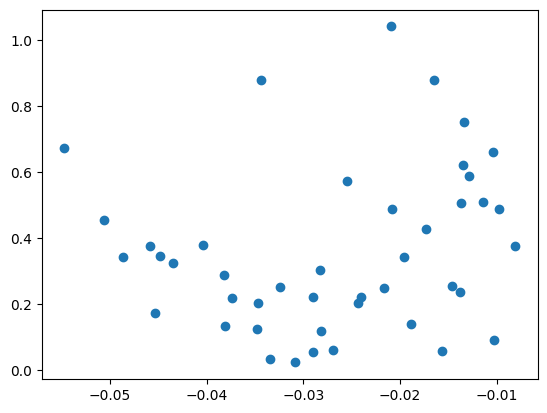

In [533]:
plt.scatter(X['ent_dmg'].values, diff)

In [484]:
train_model(default_drops, return_diff=True)

array([0.32878155, 0.20058787, 1.38866424, 1.57923755, 1.49579301,
       1.56173894, 0.91713601, 0.20036061, 0.28103081, 1.33237321,
       1.00924768, 0.3545753 , 0.32560983, 0.20048794, 1.20282506,
       2.05263385, 0.28106339, 0.36957351, 0.81370491, 0.88201257,
       0.82093067, 0.27682266, 0.10612612, 0.4719228 , 0.19638059,
       1.41575954, 0.32722504, 2.18073817, 0.18990158, 0.19271509,
       0.52333343, 1.0577888 , 0.26928991, 1.83074692, 1.00200255,
       1.67175119, 0.56367029, 0.04218612, 1.67406532, 1.39833818,
       1.01447021, 0.4141582 , 1.01889052, 0.0728092 ])

In [485]:
order = np.flip(np.argsort(np.abs(reg.coef_)))

In [486]:
np.flip(np.sort(np.abs(reg.coef_)))

array([2.46165599e+01, 2.31842896e+01, 1.98299668e+01, 1.96431555e+01,
       1.95332186e+01, 1.02513661e+01, 9.95483719e+00, 8.93437505e+00,
       8.15043073e+00, 7.81297918e+00, 7.12043084e+00, 6.16601988e+00,
       3.53538928e+00, 2.64522977e+00, 2.05902719e+00, 2.05656722e+00,
       9.49994253e-01, 6.35857703e-01, 6.35857703e-01, 5.05186728e-01,
       4.72785119e-01, 4.68870692e-01, 3.29203811e-01, 2.44080575e-01,
       2.20847642e-01, 2.07764538e-01, 2.01036179e-01, 1.52325662e-01,
       1.09432421e-01, 9.48231228e-02, 8.59502098e-02, 8.37875345e-02,
       6.36137204e-02, 4.46066754e-02, 3.87890071e-02, 3.06978509e-02,
       1.47038773e-02, 6.11118082e-03, 1.30566626e-03])

In [491]:
np.array(list(train_df.drop(columns=default_drops).keys()))[order]

array(['comb_dmg', 'ent_dmg', 'mean_dmg', 'dmg_mass', 'uncert_mass',
       'ent>0.4_thresh_dmg', 'ent>0.3_thresh_dmg', 'comb>0.4_thresh_dmg',
       'comb>0.3_thresh_dmg', 'comb>0.5_thresh_dmg', 'mean_thresh_dmg',
       'ent>0.5_thresh_dmg', 'comb>0.2_thresh_dmg', 'ent>0.2_thresh_dmg',
       'ent>0.1_thresh_dmg', 'mean_mass',
       '(dmg-mean_scaled)/surface_area', 'sbjGroup_1', 'sbjGroup_0',
       'PVWMH_3.0', 'comb>0.1_thresh_dmg', 'PVWMH_0.0', 'hyperlipidaemia',
       'PVWMH_1.0', 'ICV', 'PVWMH_2.0', 'max slice damages', 'DWMH_2.0',
       'diabetes', 'DWMH_3.0', 'age', 'CSPVS', 'DWMH_1.0', 'oldLes',
       'hypertension', 'BGPVS', 'sex', 'DWMH_0.0', 'micrBld'],
      dtype='<U30')

In [493]:
train_df['comb_dmg'].values

array([ 1.01812775e-02,  1.23724096e-02,  4.67529016e-03,  6.67520667e-03,
        3.36215654e-02,  7.99533884e-02,  8.01502470e-02,  6.13719110e-02,
        5.01997758e-01,  1.55582951e-02,  4.43988473e-01,  8.22823961e-02,
        4.29173472e-02,  2.92013142e-02, -4.73228472e-03,  3.62373036e-01,
        2.70270623e-02,  5.42128091e-02,  4.60496280e-01,  2.52568756e-01,
        3.05421725e-02,  5.60064323e-01,  4.59626397e-03,  2.89890250e-01,
        1.22019384e-01,  1.23803619e+00,  8.45164700e-03,  3.57029806e-02,
        3.90196528e-03,  3.55560670e-01,  9.54533507e-02,  1.25722003e-02,
        1.31224612e-01,  1.91506018e-02,  4.56262999e-02,  9.86315940e-02,
        4.22575024e-02,  7.52203252e-02,  1.27695972e-02,  2.19881765e-02,
        6.10475216e-01,  3.19290187e-01,  1.41410005e-01,  3.32464045e-01,
        1.49043363e-02,  7.63947868e-02,  1.44886688e-01,  1.21144275e-01,
        4.04875643e-01,  1.03705344e-02,  4.02922980e-02,  8.83804521e-02,
        1.78182540e-01,  

In [2314]:
from pandas.plotting import table

In [2310]:
result_df = pd.DataFrame(rows)
sel_result = result_df.loc[result_df['key'].isin(["age", "ICV", "BGPVS", "CSPVS", 'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0'])]
sel_result.to_csv("result_robust.csv")
sel_result

,key,MSE (ClinScore),MSE (+ mean seg),MSE (+ u_map)
0,age,0.925,0.731,0.607
5,ICV,0.703,0.692,0.677
6,BGPVS,0.640,0.512,0.524
7,CSPVS,1.011,0.987,1.004
12,PVWMH_0.0,0.000,0.000,0.000
13,PVWMH_1.0,0.178,0.129,0.121
14,PVWMH_2.0,0.271,0.285,0.269
15,PVWMH_3.0,0.108,0.107,0.104
16,DWMH_0.0,0.091,0.091,0.085
17,DWMH_1.0,0.249,0.231,0.227


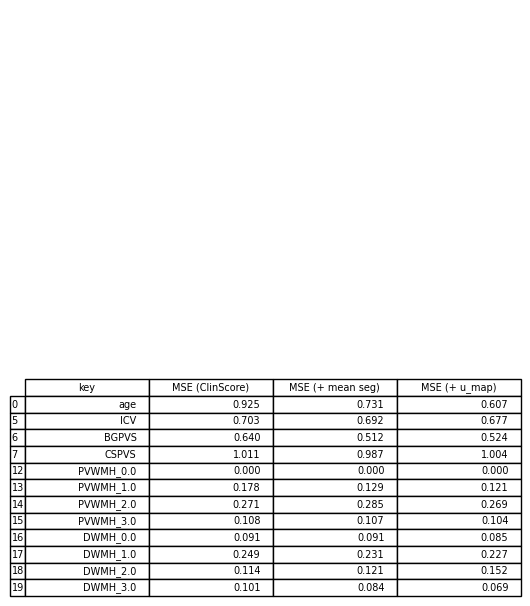

In [2307]:
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

table(ax, result_df.loc[result_df['key'].isin(["age", "ICV", "BGPVS", "CSPVS", 'PVWMH_0.0', 'PVWMH_1.0', 'PVWMH_2.0', 'PVWMH_3.0', 'DWMH_0.0', 'DWMH_1.0', 'DWMH_2.0', 'DWMH_3.0'])])

plt.savefig("results_robust")

In [2233]:
# okay, tomorrow morning, I need to write this up!!!!

In [2234]:
X_train.keys()

Index(['age', 'sex', 'diabetes', 'hypertension', 'hyperlipidaemia', 'ICV',
       'BGPVS', 'CSPVS', 'oldLes', 'micrBld', 'sbjGroup_0', 'sbjGroup_1'],
      dtype='object')

In [2235]:
len(X_train), len(X_test)

(173, 44)

In [2139]:
#X_train['wm1+2/dmg>0.1_damage'].values

In [2140]:
reg.fit(X_train, y_train)

LinearRegression()

In [2237]:
# X, y = X_train, y_train
X, y = X_test, y_test
np.abs((reg.predict(X) - y).values).mean()

In [1942]:
order = np.flip(np.argsort(np.abs(reg.coef_))) # we want the largest absolute value coefficients...

In [1929]:
# the coefficients do use stroke fields so this is interesting!!!
np.array(list(X.keys()))[order]

array(['wm1/dmg>0.4_damage', 'dmg_mass', 'wm1/dmg>0.2_damage',
       'mean_mass', 'wm1/dmg>0.1_damage', 'wm1/dmg>0.5_damage',
       'wm1/wmh_damage', 'uncert_mass', 'wm1/dmg>0.3_damage',
       'wm1/umap_aware_damage', '(dmg-mean_scaled)/surface_area',
       'hyperlipidaemia', 'sbjGroup_0', 'sbjGroup_1', 'smoking_0.0',
       'smoking_2.0', 'CSPVS', 'sex', 'deepAtrophy', 'BGPVS', 'age',
       'diabetes', 'supAtrophy', 'max slice damages', 'smoking_1.0',
       'micrBld', 'oldLes', 'ICV'], dtype='<U30')

In [997]:
reg.coef_[order]

array([-5.47846685e+00,  2.43727558e+00,  1.47305454e+00,  1.31313084e+00,
       -7.24913102e-01,  6.72548253e-01,  5.56612494e-01,  1.22718296e-01,
        1.00691307e-01,  7.77490317e-02,  5.98586216e-02,  4.80557570e-02,
        4.66300278e-02, -4.21664795e-02,  3.60967436e-02, -3.55825522e-02,
       -3.47169065e-02,  3.36824844e-02, -3.15351540e-02,  3.15351540e-02,
       -3.00225012e-02, -2.80267073e-02, -2.74397478e-02, -2.71490582e-02,
        1.92654639e-02,  1.72536695e-02,  5.64258630e-03, -3.95372438e-03,
       -2.74304110e-03,  2.71006592e-03, -5.31970190e-04])

### TODO:
get in all the data from the training images as well
build a train-test split
do these comparisons for each biomarker, making sure to mask out relevant information.
do 4 models, so that is: 
    - no mean wmh or  umap
    - with mean wmh
    - with umap
    - with both

### Chat GPTs comments

You could perform a statistical analysis to examine the relationship between the uncertainty maps and the various clinical factors (e.g., incidence of stroke, smoking status, blood pressure, brain atrophy scores) that you have for each brain scan. This could help you determine if the uncertainty maps are capturing other clinical information such as stroke risk.

One approach could be to use a regression analysis, where you treat the uncertainty maps as the dependent variable and the clinical factors as the independent variables. You could also consider using a machine learning algorithm, such as random forests or gradient boosting, to identify the most important predictors of uncertainty maps.

You should also make sure to account for the dependence between slices of the same MRI scan, such as using a mixed effects model. Additionally, you should validate your model using techniques such as cross-validation to ensure its robustness and generalizability to new data.

It is also important to interpret your results carefully and consider any potential confounding factors that may influence the relationships you observe.

---

Yes, that's a good point. The WMH burden could be a confounding factor in your analysis. You could account for this by including the total WMH burden as a predictor in your regression analysis or machine learning model.

Additionally, you could consider normalizing the uncertainty maps by the total WMH burden, so that the uncertainty is expressed as a proportion of the total WMH burden. This might help to account for the effect of the total WMH burden on the uncertainty maps.

It might also be useful to perform subgroup analysis based on the level of WMH burden, to examine if the relationship between the uncertainty maps and clinical factors is different for different levels of WMH burden.

Overall, it's important to be cautious when interpreting the results and to consider any potential confounding factors that might influence the relationships observed.

---

A mixed effects model is a type of statistical model that accounts for both fixed and random effects. In the context of your imaging data, each MRI scan can be considered a random effect, while the clinical factors you are interested in examining (e.g., incidence of stroke, smoking status, blood pressure, brain atrophy scores) would be considered fixed effects.

The mixed effects model accounts for the dependence between slices of the same MRI scan by including a random intercept for each scan. The random intercept is a random variable that represents the mean difference between each scan and the overall mean. The random intercept captures the within-scan dependence and adjusts the standard errors of the regression coefficients, making them more appropriate for the correlated data structure.

In essence, a mixed effects model allows you to estimate the effect of the clinical factors on the uncertainty maps while accounting for the dependence between slices of the same MRI scan. The model can be estimated using maximum likelihood or Bayesian methods.

It's important to note that the use of mixed effects models assumes that the slices within a scan are correlated, but not necessarily identically distributed. If the slices are not correlated, a mixed effects model may not be necessary.

**Note uesful comments from this**: just include mean volume as a predictor in our linear model when trying to see which parameters are important... Its a good idea actually to look at the slice by slice effects. Do som standard machine learning bits here. A random forest might be a good idea.

### Regression analysis